In [1]:
import os
import pdb
import h5py
import pickle
from collections import defaultdict

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr
from tqdm import tqdm

# Config

In [2]:
geuvadis_eQTL_dir = "/clusterfs/nilah/Geuvadis/E-GEUV-1/analysis_results"
geuvadis_genotypes_dir = "/clusterfs/nilah/Geuvadis/E-GEUV-1/genotypes/"
data_dir = "/clusterfs/nilah/ruchir/src/finetuning-enformer/finetuning/data/h5_bins_384_chrom_split/"
root_save_dir = "/global/scratch/users/aniketh/finetune-enformer/"
code_dir = "/global/home/users/aniketh/finetuning-enformer/"
fasta_path = "/clusterfs/nilah/aniketh/hg19/hg19.fa"

models_dir = os.path.join(root_save_dir, "saved_models")
test_preds_dir = os.path.join(root_save_dir, "test_preds_final")
ISM_preds_dir = os.path.join(root_save_dir, "ISM")

train_h5_path = os.path.join(data_dir, "train.h5")
val_h5_path = os.path.join(data_dir, "val.h5")
test_h5_path = os.path.join(data_dir, "test.h5")
train_afs_path = os.path.join(root_save_dir, "train.h5.afs.pkl")

GEUVADIS_COUNTS_PATH = "../process_geuvadis_data/log_tpm/corrected_log_tpm.annot.csv.gz"
GENE_CLASS_PATH = os.path.join(
    code_dir, "finetuning", "data", "h5_bins_384_chrom_split", "gene_class.csv"
)
BASELINE_PREDS_PATH = "../baseline/baseline_enformer.384_bins.rc.csv"
PREDIXCAN_PREDS_PATH = (
    "../predixcan_lite/h5_bins_384_chrom_split/384_bins_no_cv/preds.csv"
)
PREDIXCAN_COEFS_PATH = (
    "../predixcan_lite/h5_bins_384_chrom_split/384_bins_no_cv/coefs.csv"
)

all_main_run_names = {
    # "classification": "NCCL_P2P_DISABLE=1 python finetuning/train_pairwise_classification_parallel_h5_dataset_dynamic_sampling_dataset.py {train_h5_path} {val_h5_path} {run_name} {models_dir} --batch_size 1 --lr 0.0001 --weight_decay 0.001 --data_seed {data_seed} --resume_from_checkpoint",
    "regression": "NCCL_P2P_DISABLE=1 python finetuning/train_pairwise_regression_parallel_h5_dataset.py {train_h5_path} {val_h5_path} {run_name} {models_dir} --batch_size 1 --lr 0.0001 --weight_decay 0.001 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint",
    # "single_regression_counts": "NCCL_P2P_DISABLE=1 python finetuning/train_single_counts_parallel_h5_dataset.py {train_h5_path} {val_h5_path} {run_name} {models_dir} --batch_size 2 --lr 0.0001 --weight_decay 0.001 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint",
    #     "single_regression": "NCCL_P2P_DISABLE=1 python finetuning/train_single_parallel_h5_dataset.py {train_h5_path} {val_h5_path} {run_name} {models_dir} --batch_size 2 --lr 0.0001 --weight_decay 0.001 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint", ###DOEST PERFORM WELL, NOT USED
    # "joint_classification": "NCCL_P2P_DISABLE=1 python finetuning/train_pairwise_classification_with_enformer_data_parallel_h5_dynamic_sampling_dataset.py {train_h5_path} {val_h5_path} {enformer_data_dir} {run_name} {models_dir} --batch_size 1 --lr 0.0005 --weight_decay 0.005 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint",
    # "joint_regression": "NCCL_P2P_DISABLE=1 python finetuning/train_pairwise_regression_with_enformer_data_parallel_h5_dynamic_sampling_dataset.py {train_h5_path} {val_h5_path} {enformer_data_dir} {run_name} {models_dir} --batch_size 1 --lr 0.0005 --weight_decay 0.005 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint",
    "baseline": "",
}
all_seeds = [42, 97, 7]
train_h5 = h5py.File(train_h5_path, "r")
context_size = train_h5["seqs"][0].shape[1]
train_h5.close()

In [3]:
ALL_PREDS_PATHS = {}

# MAIN TEST RUNS
for run in all_main_run_names:
    if run != "baseline":
        for i, seed in enumerate(all_seeds):
            train_cmd_template = all_main_run_names[run]
            lr_used_during_training = train_cmd_template.split("--lr ")[-1].split(" ")[
                0
            ]
            wd_used_during_training = train_cmd_template.split("--weight_decay ")[
                -1
            ].split(" ")[0]
            rcprob_used_during_training = 0.5
            rsmax_used_during_training = 3

            model_name = f"{run}_data_seed_{seed}_lr_{lr_used_during_training}_wd_{wd_used_during_training}_rcprob_{rcprob_used_during_training}_rsmax_{rsmax_used_during_training}"
            ALL_PREDS_PATHS[model_name] = os.path.join(ISM_preds_dir, model_name)
    else:
        ALL_PREDS_PATHS[run] = os.path.join(ISM_preds_dir, run)

test_h5 = h5py.File(test_h5_path, "r")

# Read and collect ISM scores for every population split gene

In [4]:
# read base files required for gene info
gene_class_df = pd.read_csv(GENE_CLASS_PATH)
population_split_genes = gene_class_df[
    gene_class_df["class"] == "yri_split"
].reset_index(drop=True)
print(f"Number of population-split genes: {len(population_split_genes)}")

# read train set allele frequencies to extract variants seen during training
# this file is computed while performing the analysis on subsetting variants at different frequency thresholds
with open(train_afs_path, "rb") as f:
    train_afs = pickle.load(f)

Number of population-split genes: 200


In [5]:
# read ISM scores for every gene
all_ism_scores = {}
all_baseline_enformer_ism_scores = {}
all_finetuned_enformer_predictions = {}
all_baseline_enformer_predictions = {}
all_is_ref = {}

for gene in tqdm(population_split_genes["gene"].unique()):
    all_ism_scores[gene] = np.zeros((context_size, 4))
    all_finetuned_enformer_predictions[gene] = np.zeros((context_size, 4))
    all_baseline_enformer_predictions[gene] = np.zeros((context_size, 4))

    n_models_with_ism_scores = 0
    for model in ALL_PREDS_PATHS:
        if model == "baseline":
            continue
        if not os.path.exists(
            os.path.join(ALL_PREDS_PATHS[model], gene, "ism_scores.npz")
        ):
            print(
                f"{model}: ISM scores for {gene} have not been computed yet, skipping..."
            )
            continue

        ism_scores = np.load(
            os.path.join(ALL_PREDS_PATHS[model], gene, "ism_scores.npz")
        )
        all_ism_scores[gene] += ism_scores["ism_scores"][0]
        all_finetuned_enformer_predictions[gene] += ism_scores["preds"][0]
        if gene not in all_is_ref:
            all_is_ref[gene] = ism_scores["is_refs"][0]
        n_models_with_ism_scores += 1

    if n_models_with_ism_scores == 0:
        all_ism_scores.pop(gene)
        all_finetuned_enformer_predictions.pop(gene)
    else:
        all_ism_scores[gene] /= n_models_with_ism_scores
        all_finetuned_enformer_predictions[gene] /= n_models_with_ism_scores

for gene in tqdm(population_split_genes["gene"].unique()):
    model = "baseline"
    if not os.path.exists(os.path.join(ALL_PREDS_PATHS[model], gene, "ism_scores.npz")):
        print(f"{model}: ISM scores for {gene} have not been computed yet, skipping...")
        continue

    ism_scores = np.load(os.path.join(ALL_PREDS_PATHS[model], gene, "ism_scores.npz"))
    all_baseline_enformer_ism_scores[gene] = ism_scores["ism_scores"][0]
    all_baseline_enformer_predictions[gene] = ism_scores["preds"][0]

100%|██████████| 200/200 [00:11<00:00, 18.13it/s]


# Prepare the list of variants seen and unseen during training

In [6]:
all_gene_info = pd.read_csv(
    "/clusterfs/nilah/personalized_expression/eur_eqtl_gene_list.csv",
    names=["gene_id", "Chr", "Coord", "gene_name", "strand"],
)
GEUVADIS_COUNTS = pd.read_csv(GEUVADIS_COUNTS_PATH)
all_gene_info = all_gene_info.merge(
    GEUVADIS_COUNTS, left_on="gene_id", right_on="stable_id", how="inner"
).reset_index(drop=True)

train_h5 = h5py.File(train_h5_path, "r")
train_genes = train_h5["genes"][:].astype(str)

val_h5 = h5py.File(val_h5_path, "r")
val_genes = val_h5["genes"][:].astype(str)

test_genes = test_h5["genes"][:].astype(str)

all_variants_in_data = {}
all_train_variants = {}
all_train_variants_afs = {}
all_test_val_exclusive_variants = {}
all_other_variants_exclude_positions_with_variants_in_data = {}

for gene in tqdm(population_split_genes["gene"].unique()):
    gene_info = all_gene_info[all_gene_info["our_gene_name"] == gene].iloc[0]
    print(gene, gene_info["Chr_x"], gene_info["Coord_x"], gene_info["strand"])
    train_gene_seqs = train_h5["seqs"][train_genes == gene]
    val_gene_seqs = val_h5["seqs"][val_genes == gene]
    test_gene_seqs = test_h5["seqs"][test_genes == gene]

    # get variants in each split
    train_variants = np.any(train_gene_seqs > 0, axis=(0, 1))  # (seqlen, 4)
    val_variants = np.any(val_gene_seqs > 0, axis=(0, 1))
    test_variants = np.any(test_gene_seqs > 0, axis=(0, 1))
    gene_train_afs = train_afs[gene]
    if gene_info["strand"] == "+":
        train_variants = train_variants[:-1]
        val_variants = val_variants[:-1]
        test_variants = test_variants[:-1]
        gene_train_afs = gene_train_afs[:-1]
    else:
        train_variants = train_variants[1:]
        val_variants = val_variants[1:]
        test_variants = test_variants[1:]
        gene_train_afs = gene_train_afs[1:]

    all_ism_scores[gene] = all_ism_scores[gene][1:]
    all_baseline_enformer_ism_scores[gene] = all_baseline_enformer_ism_scores[gene][1:]
    all_is_ref[gene] = all_is_ref[gene][1:]
    all_finetuned_enformer_predictions[gene] = all_finetuned_enformer_predictions[gene][
        1:
    ]
    all_baseline_enformer_predictions[gene] = all_baseline_enformer_predictions[gene][
        1:
    ]

    all_train_variants[gene] = train_variants.copy()

    # get all variants
    all_variants = np.stack([train_variants, val_variants, test_variants])
    all_variants = np.any(all_variants, axis=0)
    all_variants_in_data[gene] = all_variants.copy()

    # get that are not present in the train set but are found in the val or test set
    test_val_exclusive_variants = np.logical_xor(all_variants, train_variants)
    all_test_val_exclusive_variants[gene] = test_val_exclusive_variants

    # now subtract reference from all variant matrices
    all_train_variants[gene] = (all_train_variants[gene] - all_is_ref[gene]) > 0
    all_test_val_exclusive_variants[gene] = (
        all_test_val_exclusive_variants[gene] - all_is_ref[gene]
    ) > 0
    all_variants_in_data[gene] = (all_variants_in_data[gene] - all_is_ref[gene]) > 0

    # add AFs for train variants
    all_train_variants_afs[gene] = gene_train_afs[all_train_variants[gene]]

    # get all other variants at positions which don't have variants in the data
    all_other_variants_exclude_positions_with_variants_in_data[gene] = np.ones(
        all_variants_in_data[gene].shape
    )
    all_other_variants_exclude_positions_with_variants_in_data[gene][
        all_variants_in_data[gene].sum(axis=-1) > 0
    ] = 0
    all_other_variants_exclude_positions_with_variants_in_data[gene] = (
        all_other_variants_exclude_positions_with_variants_in_data[gene]
        - all_is_ref[gene]
    ) > 0

    n_train_variants = all_train_variants[gene].sum()
    n_test_val_exclusive_variants = all_test_val_exclusive_variants[gene].sum()
    n_variants_in_data = all_variants_in_data[gene].sum()
    n_other_variants_exclude_positions_with_variants_in_data = (
        all_other_variants_exclude_positions_with_variants_in_data[gene].sum()
    )
    assert (n_train_variants + n_test_val_exclusive_variants) == n_variants_in_data
    assert n_other_variants_exclude_positions_with_variants_in_data >= (
        (all_variants_in_data[gene].shape[0] - n_variants_in_data) * 3
    )
    print(
        f"Gene {gene}, n train variants = {n_train_variants} (avg AF = {all_train_variants_afs[gene].mean()}, n test-val exclusive variants = {n_test_val_exclusive_variants}, n variants in data = {n_variants_in_data}, n_other_variants_exclude_positions_with_variants_in_data = {n_other_variants_exclude_positions_with_variants_in_data}"
    )

  0%|          | 0/200 [00:00<?, ?it/s]

borcs7 10 104613980 +


  0%|          | 1/200 [00:04<13:17,  4.01s/it]

Gene borcs7, n train variants = 266 (avg AF = 0.1176450327038765, n test-val exclusive variants = 77, n variants in data = 343, n_other_variants_exclude_positions_with_variants_in_data = 146424
rtn4 2 55339757 -


  1%|          | 2/200 [00:07<12:13,  3.70s/it]

Gene rtn4, n train variants = 357 (avg AF = 0.19502907991409302, n test-val exclusive variants = 175, n variants in data = 532, n_other_variants_exclude_positions_with_variants_in_data = 145857
borcs5 12 12510013 +


  2%|▏         | 3/200 [00:11<11:53,  3.62s/it]

Gene borcs5, n train variants = 330 (avg AF = 0.08937540650367737, n test-val exclusive variants = 171, n variants in data = 501, n_other_variants_exclude_positions_with_variants_in_data = 145950
epdr1 7 37723446 +


  2%|▏         | 4/200 [00:14<11:37,  3.56s/it]

Gene epdr1, n train variants = 234 (avg AF = 0.14122821390628815, n test-val exclusive variants = 155, n variants in data = 389, n_other_variants_exclude_positions_with_variants_in_data = 146286
smug1 12 54582778 -


  2%|▎         | 5/200 [00:18<11:30,  3.54s/it]

Gene smug1, n train variants = 200 (avg AF = 0.15712538361549377, n test-val exclusive variants = 148, n variants in data = 348, n_other_variants_exclude_positions_with_variants_in_data = 146409
spx 12 21679241 +


  3%|▎         | 6/200 [00:21<11:33,  3.58s/it]

Gene spx, n train variants = 337 (avg AF = 0.22985690832138062, n test-val exclusive variants = 120, n variants in data = 457, n_other_variants_exclude_positions_with_variants_in_data = 146082
ppp3r1 2 68488362 -


  4%|▎         | 7/200 [00:25<11:24,  3.55s/it]

Gene ppp3r1, n train variants = 196 (avg AF = 0.1517115831375122, n test-val exclusive variants = 153, n variants in data = 349, n_other_variants_exclude_positions_with_variants_in_data = 146406
ccdc50 3 191046866 +


  4%|▍         | 8/200 [00:28<11:21,  3.55s/it]

Gene ccdc50, n train variants = 305 (avg AF = 0.120013028383255, n test-val exclusive variants = 219, n variants in data = 524, n_other_variants_exclude_positions_with_variants_in_data = 145881
dock8-as1 9 215893 -


  4%|▍         | 9/200 [00:32<11:11,  3.51s/it]

Gene dock8-as1, n train variants = 337 (avg AF = 0.15360847115516663, n test-val exclusive variants = 240, n variants in data = 577, n_other_variants_exclude_positions_with_variants_in_data = 145722
ensg00000232116 9 45484572 +


  5%|▌         | 10/200 [00:35<11:06,  3.51s/it]

Gene ensg00000232116, n train variants = 29 (avg AF = 0.1274913102388382, n test-val exclusive variants = 8, n variants in data = 37, n_other_variants_exclude_positions_with_variants_in_data = 147342
linc02397 12 92815307 +


  6%|▌         | 11/200 [00:39<11:06,  3.53s/it]

Gene linc02397, n train variants = 294 (avg AF = 0.137448251247406, n test-val exclusive variants = 251, n variants in data = 545, n_other_variants_exclude_positions_with_variants_in_data = 145818
tcaf1 7 143599291 -


  6%|▌         | 12/200 [00:42<11:01,  3.52s/it]

Gene tcaf1, n train variants = 187 (avg AF = 0.08390979468822479, n test-val exclusive variants = 179, n variants in data = 366, n_other_variants_exclude_positions_with_variants_in_data = 146355
hspbap1 3 122512671 -


  6%|▋         | 13/200 [00:46<10:51,  3.48s/it]

Gene hspbap1, n train variants = 225 (avg AF = 0.1620115488767624, n test-val exclusive variants = 93, n variants in data = 318, n_other_variants_exclude_positions_with_variants_in_data = 146499
prob1 5 138730885 -


  7%|▋         | 14/200 [00:49<10:55,  3.52s/it]

Gene prob1, n train variants = 173 (avg AF = 0.16989269852638245, n test-val exclusive variants = 94, n variants in data = 267, n_other_variants_exclude_positions_with_variants_in_data = 146652
atp7b 13 52585630 -


  8%|▊         | 15/200 [00:53<10:54,  3.54s/it]

Gene atp7b, n train variants = 222 (avg AF = 0.1624169945716858, n test-val exclusive variants = 126, n variants in data = 348, n_other_variants_exclude_positions_with_variants_in_data = 146409
cx3cr1 3 39323226 -


  8%|▊         | 16/200 [00:56<10:50,  3.54s/it]

Gene cx3cr1, n train variants = 272 (avg AF = 0.18331198394298553, n test-val exclusive variants = 219, n variants in data = 491, n_other_variants_exclude_positions_with_variants_in_data = 145980
rps14 5 149829319 -


  8%|▊         | 17/200 [01:00<10:42,  3.51s/it]

Gene rps14, n train variants = 296 (avg AF = 0.08506384491920471, n test-val exclusive variants = 202, n variants in data = 498, n_other_variants_exclude_positions_with_variants_in_data = 145959
glrx3 10 131934663 +


  9%|▉         | 18/200 [01:03<10:40,  3.52s/it]

Gene glrx3, n train variants = 350 (avg AF = 0.1517169028520584, n test-val exclusive variants = 123, n variants in data = 473, n_other_variants_exclude_positions_with_variants_in_data = 146034
linc01006 7 156433286 -


 10%|▉         | 19/200 [01:07<10:37,  3.52s/it]

Gene linc01006, n train variants = 251 (avg AF = 0.14071543514728546, n test-val exclusive variants = 225, n variants in data = 476, n_other_variants_exclude_positions_with_variants_in_data = 146025
cox17 3 119396301 -


 10%|█         | 20/200 [01:10<10:27,  3.49s/it]

Gene cox17, n train variants = 338 (avg AF = 0.18749886751174927, n test-val exclusive variants = 147, n variants in data = 485, n_other_variants_exclude_positions_with_variants_in_data = 145998
c12orf73 12 104359486 -


 10%|█         | 21/200 [01:14<10:26,  3.50s/it]

Gene c12orf73, n train variants = 310 (avg AF = 0.1615714728832245, n test-val exclusive variants = 123, n variants in data = 433, n_other_variants_exclude_positions_with_variants_in_data = 146154
parl 3 183602721 -


 11%|█         | 22/200 [01:17<10:25,  3.52s/it]

Gene parl, n train variants = 303 (avg AF = 0.1644260734319687, n test-val exclusive variants = 127, n variants in data = 430, n_other_variants_exclude_positions_with_variants_in_data = 146163
thumpd3 3 9404526 +


 12%|█▏        | 23/200 [01:21<10:22,  3.51s/it]

Gene thumpd3, n train variants = 281 (avg AF = 0.13554692268371582, n test-val exclusive variants = 126, n variants in data = 407, n_other_variants_exclude_positions_with_variants_in_data = 146232
hat1 2 172778958 +


 12%|█▏        | 24/200 [01:24<10:21,  3.53s/it]

Gene hat1, n train variants = 267 (avg AF = 0.10183371603488922, n test-val exclusive variants = 68, n variants in data = 335, n_other_variants_exclude_positions_with_variants_in_data = 146448
rab33b 4 140374386 +


 12%|█▎        | 25/200 [01:28<10:16,  3.52s/it]

Gene rab33b, n train variants = 214 (avg AF = 0.11720826476812363, n test-val exclusive variants = 173, n variants in data = 387, n_other_variants_exclude_positions_with_variants_in_data = 146292
arhgap22 10 49864310 -


 13%|█▎        | 26/200 [01:31<10:11,  3.51s/it]

Gene arhgap22, n train variants = 293 (avg AF = 0.12734967470169067, n test-val exclusive variants = 231, n variants in data = 524, n_other_variants_exclude_positions_with_variants_in_data = 145881
adamts6 5 64777747 -


 14%|█▎        | 27/200 [01:35<10:10,  3.53s/it]

Gene adamts6, n train variants = 238 (avg AF = 0.14368592202663422, n test-val exclusive variants = 153, n variants in data = 391, n_other_variants_exclude_positions_with_variants_in_data = 146280
nup35 2 183982241 +


 14%|█▍        | 28/200 [01:38<10:03,  3.51s/it]

Gene nup35, n train variants = 362 (avg AF = 0.2367749661207199, n test-val exclusive variants = 117, n variants in data = 479, n_other_variants_exclude_positions_with_variants_in_data = 146016
sdha 5 218356 +


 14%|█▍        | 29/200 [01:42<09:58,  3.50s/it]

Gene sdha, n train variants = 492 (avg AF = 0.13448821008205414, n test-val exclusive variants = 157, n variants in data = 649, n_other_variants_exclude_positions_with_variants_in_data = 145506
arhgap24 4 86396267 +


 15%|█▌        | 30/200 [01:45<09:54,  3.49s/it]

Gene arhgap24, n train variants = 182 (avg AF = 0.05797795578837395, n test-val exclusive variants = 192, n variants in data = 374, n_other_variants_exclude_positions_with_variants_in_data = 146331
al160291.1 10 27532059 +


 16%|█▌        | 31/200 [01:49<09:48,  3.48s/it]

Gene al160291.1, n train variants = 460 (avg AF = 0.2259008139371872, n test-val exclusive variants = 113, n variants in data = 573, n_other_variants_exclude_positions_with_variants_in_data = 145734
mxi1 10 111967363 +


 16%|█▌        | 32/200 [01:52<09:46,  3.49s/it]

Gene mxi1, n train variants = 261 (avg AF = 0.0758901834487915, n test-val exclusive variants = 138, n variants in data = 399, n_other_variants_exclude_positions_with_variants_in_data = 146256
pigo 9 35096591 -


 16%|█▋        | 33/200 [01:56<09:44,  3.50s/it]

Gene pigo, n train variants = 211 (avg AF = 0.16589127480983734, n test-val exclusive variants = 99, n variants in data = 310, n_other_variants_exclude_positions_with_variants_in_data = 146523
ensg00000204807 9 45733559 +


 17%|█▋        | 34/200 [01:59<09:43,  3.52s/it]

Gene ensg00000204807, n train variants = 66 (avg AF = 0.2324390709400177, n test-val exclusive variants = 7, n variants in data = 73, n_other_variants_exclude_positions_with_variants_in_data = 147234
nme6 3 48343175 -


 18%|█▊        | 35/200 [02:03<09:37,  3.50s/it]

Gene nme6, n train variants = 196 (avg AF = 0.12558509409427643, n test-val exclusive variants = 78, n variants in data = 274, n_other_variants_exclude_positions_with_variants_in_data = 146631
stambpl1 10 90639491 +


 18%|█▊        | 36/200 [02:06<09:33,  3.50s/it]

Gene stambpl1, n train variants = 256 (avg AF = 0.07064101099967957, n test-val exclusive variants = 139, n variants in data = 395, n_other_variants_exclude_positions_with_variants_in_data = 146268
fam43a 3 194406622 +


 18%|█▊        | 37/200 [02:10<09:29,  3.49s/it]

Gene fam43a, n train variants = 341 (avg AF = 0.2354157269001007, n test-val exclusive variants = 150, n variants in data = 491, n_other_variants_exclude_positions_with_variants_in_data = 145980
slc16a9 10 61495760 -


 19%|█▉        | 38/200 [02:14<09:34,  3.54s/it]

Gene slc16a9, n train variants = 274 (avg AF = 0.13998079299926758, n test-val exclusive variants = 174, n variants in data = 448, n_other_variants_exclude_positions_with_variants_in_data = 146110
ehd3 2 31456880 +


 20%|█▉        | 39/200 [02:17<09:24,  3.51s/it]

Gene ehd3, n train variants = 357 (avg AF = 0.18240690231323242, n test-val exclusive variants = 193, n variants in data = 550, n_other_variants_exclude_positions_with_variants_in_data = 145803
ensg00000260006 2 201689396 +


 20%|██        | 40/200 [02:20<09:20,  3.50s/it]

Gene ensg00000260006, n train variants = 196 (avg AF = 0.16161924600601196, n test-val exclusive variants = 104, n variants in data = 300, n_other_variants_exclude_positions_with_variants_in_data = 146553
sumf2 7 56131695 +


 20%|██        | 41/200 [02:24<09:22,  3.54s/it]

Gene sumf2, n train variants = 246 (avg AF = 0.11030307412147522, n test-val exclusive variants = 115, n variants in data = 361, n_other_variants_exclude_positions_with_variants_in_data = 146370
gype 4 144826716 -


 21%|██        | 42/200 [02:28<09:18,  3.53s/it]

Gene gype, n train variants = 289 (avg AF = 0.45727649331092834, n test-val exclusive variants = 300, n variants in data = 589, n_other_variants_exclude_positions_with_variants_in_data = 145686
hdhd3 9 116139279 -


 22%|██▏       | 43/200 [02:31<09:14,  3.53s/it]

Gene hdhd3, n train variants = 353 (avg AF = 0.16968144476413727, n test-val exclusive variants = 137, n variants in data = 490, n_other_variants_exclude_positions_with_variants_in_data = 145983
rasa4b 7 102184211 -


 22%|██▏       | 44/200 [02:35<09:14,  3.55s/it]

Gene rasa4b, n train variants = 10 (avg AF = 0.31972476840019226, n test-val exclusive variants = 1, n variants in data = 11, n_other_variants_exclude_positions_with_variants_in_data = 147420
mgmt 10 131265448 +


 22%|██▎       | 45/200 [02:38<09:07,  3.53s/it]

Gene mgmt, n train variants = 334 (avg AF = 0.19090259075164795, n test-val exclusive variants = 181, n variants in data = 515, n_other_variants_exclude_positions_with_variants_in_data = 145908
gsto2 10 106028631 +


 23%|██▎       | 46/200 [02:42<08:59,  3.50s/it]

Gene gsto2, n train variants = 199 (avg AF = 0.08480476588010788, n test-val exclusive variants = 240, n variants in data = 439, n_other_variants_exclude_positions_with_variants_in_data = 146136
ac104653.1 2 114600933 -


 24%|██▎       | 47/200 [02:45<08:58,  3.52s/it]

Gene ac104653.1, n train variants = 335 (avg AF = 0.22280341386795044, n test-val exclusive variants = 110, n variants in data = 445, n_other_variants_exclude_positions_with_variants_in_data = 146118
tmtc4 13 101327347 -


 24%|██▍       | 48/200 [02:49<09:03,  3.58s/it]

Gene tmtc4, n train variants = 282 (avg AF = 0.24442058801651, n test-val exclusive variants = 150, n variants in data = 432, n_other_variants_exclude_positions_with_variants_in_data = 146157
tnc 9 117880536 -


 24%|██▍       | 49/200 [02:52<08:55,  3.55s/it]

Gene tnc, n train variants = 288 (avg AF = 0.1628546565771103, n test-val exclusive variants = 187, n variants in data = 475, n_other_variants_exclude_positions_with_variants_in_data = 146028
fam117b 2 203499901 +


 25%|██▌       | 50/200 [02:56<08:45,  3.50s/it]

Gene fam117b, n train variants = 166 (avg AF = 0.10213328897953033, n test-val exclusive variants = 144, n variants in data = 310, n_other_variants_exclude_positions_with_variants_in_data = 146523
znf354b 5 178286954 +


 26%|██▌       | 51/200 [02:59<08:43,  3.51s/it]

Gene znf354b, n train variants = 533 (avg AF = 0.20489297807216644, n test-val exclusive variants = 192, n variants in data = 725, n_other_variants_exclude_positions_with_variants_in_data = 145278
spryd3 12 53473204 -


 26%|██▌       | 52/200 [03:03<08:40,  3.51s/it]

Gene spryd3, n train variants = 184 (avg AF = 0.056250832974910736, n test-val exclusive variants = 177, n variants in data = 361, n_other_variants_exclude_positions_with_variants_in_data = 146370
tmbim1 2 219157309 -


 26%|██▋       | 53/200 [03:06<08:32,  3.49s/it]

Gene tmbim1, n train variants = 229 (avg AF = 0.25812265276908875, n test-val exclusive variants = 183, n variants in data = 412, n_other_variants_exclude_positions_with_variants_in_data = 146217
ap4m1 7 99699172 +


 27%|██▋       | 54/200 [03:10<08:29,  3.49s/it]

Gene ap4m1, n train variants = 234 (avg AF = 0.08782900124788284, n test-val exclusive variants = 110, n variants in data = 344, n_other_variants_exclude_positions_with_variants_in_data = 146421
eif2ak3-dt 2 88927057 +


 28%|██▊       | 55/200 [03:13<08:35,  3.56s/it]

Gene eif2ak3-dt, n train variants = 171 (avg AF = 0.09751059114933014, n test-val exclusive variants = 112, n variants in data = 283, n_other_variants_exclude_positions_with_variants_in_data = 146604
lap3 4 17578815 +


 28%|██▊       | 56/200 [03:17<08:30,  3.55s/it]

Gene lap3, n train variants = 256 (avg AF = 0.240252286195755, n test-val exclusive variants = 185, n variants in data = 441, n_other_variants_exclude_positions_with_variants_in_data = 146130
pnpt1 2 55921045 -


 28%|██▊       | 57/200 [03:20<08:21,  3.51s/it]

Gene pnpt1, n train variants = 335 (avg AF = 0.22533661127090454, n test-val exclusive variants = 130, n variants in data = 465, n_other_variants_exclude_positions_with_variants_in_data = 146058
clstn3 12 7282294 +


 29%|██▉       | 58/200 [03:24<08:18,  3.51s/it]

Gene clstn3, n train variants = 221 (avg AF = 0.12381169945001602, n test-val exclusive variants = 156, n variants in data = 377, n_other_variants_exclude_positions_with_variants_in_data = 146322
ac108206.1 4 146977914 -


 30%|██▉       | 59/200 [03:27<08:15,  3.51s/it]

Gene ac108206.1, n train variants = 341 (avg AF = 0.12663330137729645, n test-val exclusive variants = 217, n variants in data = 558, n_other_variants_exclude_positions_with_variants_in_data = 145779
znf354a 5 178157703 -


 30%|███       | 60/200 [03:31<08:13,  3.52s/it]

Gene znf354a, n train variants = 297 (avg AF = 0.202190101146698, n test-val exclusive variants = 232, n variants in data = 529, n_other_variants_exclude_positions_with_variants_in_data = 145866
ptprn2 7 158380480 -


 30%|███       | 61/200 [03:35<08:13,  3.55s/it]

Gene ptprn2, n train variants = 242 (avg AF = 0.15131928026676178, n test-val exclusive variants = 208, n variants in data = 450, n_other_variants_exclude_positions_with_variants_in_data = 146103
vamp1 12 6580153 -


 31%|███       | 62/200 [03:38<08:08,  3.54s/it]

Gene vamp1, n train variants = 330 (avg AF = 0.20532388985157013, n test-val exclusive variants = 176, n variants in data = 506, n_other_variants_exclude_positions_with_variants_in_data = 145935
ftcdnl1 2 200715896 -


 32%|███▏      | 63/200 [03:42<08:07,  3.56s/it]

Gene ftcdnl1, n train variants = 208 (avg AF = 0.13654875755310059, n test-val exclusive variants = 105, n variants in data = 313, n_other_variants_exclude_positions_with_variants_in_data = 146514
fgf2 4 123747863 +


 32%|███▏      | 64/200 [03:46<08:24,  3.71s/it]

Gene fgf2, n train variants = 287 (avg AF = 0.042110197246074677, n test-val exclusive variants = 196, n variants in data = 483, n_other_variants_exclude_positions_with_variants_in_data = 146004
linc02361 12 132674240 -


 32%|███▎      | 65/200 [03:49<08:11,  3.64s/it]

Gene linc02361, n train variants = 404 (avg AF = 0.15039590001106262, n test-val exclusive variants = 378, n variants in data = 782, n_other_variants_exclude_positions_with_variants_in_data = 145107
mkrn2 3 12598513 +


 33%|███▎      | 66/200 [03:53<08:02,  3.60s/it]

Gene mkrn2, n train variants = 269 (avg AF = 0.18472538888454437, n test-val exclusive variants = 154, n variants in data = 423, n_other_variants_exclude_positions_with_variants_in_data = 146184
kalrn 3 123798870 +


 34%|███▎      | 67/200 [03:56<07:55,  3.58s/it]

Gene kalrn, n train variants = 174 (avg AF = 0.19496290385723114, n test-val exclusive variants = 104, n variants in data = 278, n_other_variants_exclude_positions_with_variants_in_data = 146619
lacc1 13 44453420 +


 34%|███▍      | 68/200 [04:00<07:49,  3.55s/it]

Gene lacc1, n train variants = 290 (avg AF = 0.20082779228687286, n test-val exclusive variants = 86, n variants in data = 376, n_other_variants_exclude_positions_with_variants_in_data = 146325
adk 10 75910960 +


 34%|███▍      | 69/200 [04:03<07:44,  3.55s/it]

Gene adk, n train variants = 215 (avg AF = 0.15500321984291077, n test-val exclusive variants = 124, n variants in data = 339, n_other_variants_exclude_positions_with_variants_in_data = 146436
inpp5e 9 139334274 -


 35%|███▌      | 70/200 [04:07<07:37,  3.52s/it]

Gene inpp5e, n train variants = 296 (avg AF = 0.10837671905755997, n test-val exclusive variants = 159, n variants in data = 455, n_other_variants_exclude_positions_with_variants_in_data = 146088
mrps36 5 68513587 +


 36%|███▌      | 71/200 [04:10<07:34,  3.52s/it]

Gene mrps36, n train variants = 241 (avg AF = 0.1595606952905655, n test-val exclusive variants = 88, n variants in data = 329, n_other_variants_exclude_positions_with_variants_in_data = 146466
c4orf33 4 130014472 +


 36%|███▌      | 72/200 [04:14<07:40,  3.60s/it]

Gene c4orf33, n train variants = 230 (avg AF = 0.22612683475017548, n test-val exclusive variants = 168, n variants in data = 398, n_other_variants_exclude_positions_with_variants_in_data = 146259
insig1 7 155089486 +


 36%|███▋      | 73/200 [04:18<07:33,  3.57s/it]

Gene insig1, n train variants = 369 (avg AF = 0.21270398795604706, n test-val exclusive variants = 198, n variants in data = 567, n_other_variants_exclude_positions_with_variants_in_data = 145752
aftph 2 64751465 +


 37%|███▋      | 74/200 [04:21<07:34,  3.61s/it]

Gene aftph, n train variants = 220 (avg AF = 0.09758131206035614, n test-val exclusive variants = 144, n variants in data = 364, n_other_variants_exclude_positions_with_variants_in_data = 146361
ppip5k2 5 102455853 +


 38%|███▊      | 75/200 [04:25<07:26,  3.57s/it]

Gene ppip5k2, n train variants = 258 (avg AF = 0.09342625737190247, n test-val exclusive variants = 166, n variants in data = 424, n_other_variants_exclude_positions_with_variants_in_data = 146181
gpbp1 5 56469775 +


 38%|███▊      | 76/200 [04:28<07:19,  3.54s/it]

Gene gpbp1, n train variants = 200 (avg AF = 0.09537462145090103, n test-val exclusive variants = 143, n variants in data = 343, n_other_variants_exclude_positions_with_variants_in_data = 146424
znf22-as1 10 45496336 -


 38%|███▊      | 77/200 [04:32<07:15,  3.54s/it]

Gene znf22-as1, n train variants = 258 (avg AF = 0.1499359905719757, n test-val exclusive variants = 183, n variants in data = 441, n_other_variants_exclude_positions_with_variants_in_data = 146130
magohb 12 10766222 -


 39%|███▉      | 78/200 [04:35<07:16,  3.58s/it]

Gene magohb, n train variants = 271 (avg AF = 0.2723292410373688, n test-val exclusive variants = 231, n variants in data = 502, n_other_variants_exclude_positions_with_variants_in_data = 145947
hsdl2 9 115142217 +


 40%|███▉      | 79/200 [04:39<07:08,  3.54s/it]

Gene hsdl2, n train variants = 294 (avg AF = 0.212746262550354, n test-val exclusive variants = 190, n variants in data = 484, n_other_variants_exclude_positions_with_variants_in_data = 146001
ndufc1 4 140223705 -


 40%|████      | 80/200 [04:43<07:07,  3.56s/it]

Gene ndufc1, n train variants = 229 (avg AF = 0.0912957489490509, n test-val exclusive variants = 157, n variants in data = 386, n_other_variants_exclude_positions_with_variants_in_data = 146295
chchd4 3 14166370 -


 40%|████      | 81/200 [04:46<07:03,  3.56s/it]

Gene chchd4, n train variants = 223 (avg AF = 0.13353490829467773, n test-val exclusive variants = 196, n variants in data = 419, n_other_variants_exclude_positions_with_variants_in_data = 146196
zp3 7 76026835 +


 41%|████      | 82/200 [04:50<06:56,  3.53s/it]

Gene zp3, n train variants = 362 (avg AF = 0.11668948084115982, n test-val exclusive variants = 149, n variants in data = 511, n_other_variants_exclude_positions_with_variants_in_data = 145920
fam153b 5 175487692 +


 42%|████▏     | 83/200 [04:53<06:50,  3.51s/it]

Gene fam153b, n train variants = 156 (avg AF = 0.1055045872926712, n test-val exclusive variants = 36, n variants in data = 192, n_other_variants_exclude_positions_with_variants_in_data = 146877
b3galnt1 3 160823172 -


 42%|████▏     | 84/200 [04:56<06:46,  3.51s/it]

Gene b3galnt1, n train variants = 207 (avg AF = 0.11485618352890015, n test-val exclusive variants = 182, n variants in data = 389, n_other_variants_exclude_positions_with_variants_in_data = 146286
fzd5 2 208634287 -


 42%|████▎     | 85/200 [05:00<06:44,  3.52s/it]

Gene fzd5, n train variants = 219 (avg AF = 0.1350802183151245, n test-val exclusive variants = 143, n variants in data = 362, n_other_variants_exclude_positions_with_variants_in_data = 146367
eif4b 12 53399942 +


 43%|████▎     | 86/200 [05:03<06:38,  3.50s/it]

Gene eif4b, n train variants = 252 (avg AF = 0.24642007052898407, n test-val exclusive variants = 141, n variants in data = 393, n_other_variants_exclude_positions_with_variants_in_data = 146274
tctn2 12 124155660 +


 44%|████▎     | 87/200 [05:07<06:35,  3.50s/it]

Gene tctn2, n train variants = 299 (avg AF = 0.13386109471321106, n test-val exclusive variants = 154, n variants in data = 453, n_other_variants_exclude_positions_with_variants_in_data = 146094
yipf5 5 143550278 -


 44%|████▍     | 88/200 [05:10<06:31,  3.50s/it]

Gene yipf5, n train variants = 245 (avg AF = 0.135923370718956, n test-val exclusive variants = 141, n variants in data = 386, n_other_variants_exclude_positions_with_variants_in_data = 146295
clnk 4 10686489 -


 44%|████▍     | 89/200 [05:14<06:28,  3.50s/it]

Gene clnk, n train variants = 334 (avg AF = 0.2310837209224701, n test-val exclusive variants = 185, n variants in data = 519, n_other_variants_exclude_positions_with_variants_in_data = 145896
linc02367 12 9520060 +


 45%|████▌     | 90/200 [05:17<06:22,  3.47s/it]

Gene linc02367, n train variants = 339 (avg AF = 0.2856666147708893, n test-val exclusive variants = 255, n variants in data = 594, n_other_variants_exclude_positions_with_variants_in_data = 145671
ugt2b17 4 69434245 -


 46%|████▌     | 91/200 [05:21<06:20,  3.49s/it]

Gene ugt2b17, n train variants = 357 (avg AF = 0.1995776891708374, n test-val exclusive variants = 148, n variants in data = 505, n_other_variants_exclude_positions_with_variants_in_data = 145938
linc00539 13 21922860 -


 46%|████▌     | 92/200 [05:25<06:19,  3.52s/it]

Gene linc00539, n train variants = 325 (avg AF = 0.20688776671886444, n test-val exclusive variants = 245, n variants in data = 570, n_other_variants_exclude_positions_with_variants_in_data = 145743
alad 9 116163613 -


 46%|████▋     | 93/200 [05:28<06:16,  3.52s/it]

Gene alad, n train variants = 272 (avg AF = 0.12662461400032043, n test-val exclusive variants = 119, n variants in data = 391, n_other_variants_exclude_positions_with_variants_in_data = 146280
agap6 10 51748078 +


 47%|████▋     | 94/200 [05:32<06:28,  3.66s/it]

Gene agap6, n train variants = 136 (avg AF = 0.09622909128665924, n test-val exclusive variants = 44, n variants in data = 180, n_other_variants_exclude_positions_with_variants_in_data = 146913
polr2j 7 102119354 -


 48%|████▊     | 95/200 [05:36<06:18,  3.61s/it]

Gene polr2j, n train variants = 183 (avg AF = 0.15639778971672058, n test-val exclusive variants = 100, n variants in data = 283, n_other_variants_exclude_positions_with_variants_in_data = 146604
pole4 2 75185619 +


 48%|████▊     | 96/200 [05:39<06:12,  3.58s/it]

Gene pole4, n train variants = 240 (avg AF = 0.15642839670181274, n test-val exclusive variants = 181, n variants in data = 421, n_other_variants_exclude_positions_with_variants_in_data = 146190
ensg00000182368 9 45727107 +


 48%|████▊     | 97/200 [05:43<06:05,  3.55s/it]

Gene ensg00000182368, n train variants = 72 (avg AF = 0.2182721644639969, n test-val exclusive variants = 8, n variants in data = 80, n_other_variants_exclude_positions_with_variants_in_data = 147213
znf438 10 31320866 -


 49%|████▉     | 98/200 [05:46<06:02,  3.55s/it]

Gene znf438, n train variants = 239 (avg AF = 0.1690721958875656, n test-val exclusive variants = 187, n variants in data = 426, n_other_variants_exclude_positions_with_variants_in_data = 146175
snx18 5 53813589 +


 50%|████▉     | 99/200 [05:50<05:56,  3.53s/it]

Gene snx18, n train variants = 351 (avg AF = 0.22728422284126282, n test-val exclusive variants = 153, n variants in data = 504, n_other_variants_exclude_positions_with_variants_in_data = 145941
cep19 3 196439164 -


 50%|█████     | 100/200 [05:53<05:52,  3.52s/it]

Gene cep19, n train variants = 324 (avg AF = 0.1551043838262558, n test-val exclusive variants = 220, n variants in data = 544, n_other_variants_exclude_positions_with_variants_in_data = 145821
rep15 12 27849428 +


 50%|█████     | 101/200 [05:57<05:46,  3.50s/it]

Gene rep15, n train variants = 192 (avg AF = 0.15308837592601776, n test-val exclusive variants = 199, n variants in data = 391, n_other_variants_exclude_positions_with_variants_in_data = 146280
gldc 9 6645650 -


 51%|█████     | 102/200 [06:00<05:47,  3.54s/it]

Gene gldc, n train variants = 498 (avg AF = 0.13612249493598938, n test-val exclusive variants = 232, n variants in data = 730, n_other_variants_exclude_positions_with_variants_in_data = 145263
gpr55 2 231825781 -


 52%|█████▏    | 103/200 [06:04<05:42,  3.53s/it]

Gene gpr55, n train variants = 342 (avg AF = 0.10841068625450134, n test-val exclusive variants = 261, n variants in data = 603, n_other_variants_exclude_positions_with_variants_in_data = 145644
bspry 9 116111821 +


 52%|█████▏    | 104/200 [06:07<05:43,  3.58s/it]

Gene bspry, n train variants = 332 (avg AF = 0.15180906653404236, n test-val exclusive variants = 167, n variants in data = 499, n_other_variants_exclude_positions_with_variants_in_data = 145956
enc1 5 73937249 -


 52%|█████▎    | 105/200 [06:11<05:37,  3.56s/it]

Gene enc1, n train variants = 283 (avg AF = 0.18623097240924835, n test-val exclusive variants = 162, n variants in data = 445, n_other_variants_exclude_positions_with_variants_in_data = 146118
pomgnt2 3 43147568 -


 53%|█████▎    | 106/200 [06:14<05:33,  3.54s/it]

Gene pomgnt2, n train variants = 242 (avg AF = 0.15024515986442566, n test-val exclusive variants = 248, n variants in data = 490, n_other_variants_exclude_positions_with_variants_in_data = 145983
ac079921.2 4 39135533 +


 54%|█████▎    | 107/200 [06:18<05:28,  3.54s/it]

Gene ac079921.2, n train variants = 235 (avg AF = 0.34673696756362915, n test-val exclusive variants = 172, n variants in data = 407, n_other_variants_exclude_positions_with_variants_in_data = 146232
ap3b1 5 77590579 -


 54%|█████▍    | 108/200 [06:21<05:23,  3.51s/it]

Gene ap3b1, n train variants = 265 (avg AF = 0.1713923066854477, n test-val exclusive variants = 188, n variants in data = 453, n_other_variants_exclude_positions_with_variants_in_data = 146094
gas6 13 114567046 -


 55%|█████▍    | 109/200 [06:25<05:19,  3.51s/it]

Gene gas6, n train variants = 337 (avg AF = 0.11693844944238663, n test-val exclusive variants = 181, n variants in data = 518, n_other_variants_exclude_positions_with_variants_in_data = 145899
nutm2b-as1 10 81586350 -


 55%|█████▌    | 110/200 [06:28<05:17,  3.52s/it]

Gene nutm2b-as1, n train variants = 215 (avg AF = 0.34575068950653076, n test-val exclusive variants = 59, n variants in data = 274, n_other_variants_exclude_positions_with_variants_in_data = 146631
rnaseh1-as1 2 3606082 +


 56%|█████▌    | 111/200 [06:32<05:14,  3.53s/it]

Gene rnaseh1-as1, n train variants = 346 (avg AF = 0.09885364770889282, n test-val exclusive variants = 183, n variants in data = 529, n_other_variants_exclude_positions_with_variants_in_data = 145866
tmem163 2 135476570 -


 56%|█████▌    | 112/200 [06:35<05:08,  3.50s/it]

Gene tmem163, n train variants = 221 (avg AF = 0.07773257046937943, n test-val exclusive variants = 163, n variants in data = 384, n_other_variants_exclude_positions_with_variants_in_data = 146301
fgfrl1 4 1003724 +


 56%|█████▋    | 113/200 [06:39<05:04,  3.50s/it]

Gene fgfrl1, n train variants = 367 (avg AF = 0.12130755931138992, n test-val exclusive variants = 196, n variants in data = 563, n_other_variants_exclude_positions_with_variants_in_data = 145764
fbrsl1 12 133066137 +


 57%|█████▋    | 114/200 [06:42<05:02,  3.52s/it]

Gene fbrsl1, n train variants = 375 (avg AF = 0.17883792519569397, n test-val exclusive variants = 173, n variants in data = 548, n_other_variants_exclude_positions_with_variants_in_data = 145809
prxl2c 9 99417599 -


 57%|█████▊    | 115/200 [06:46<04:58,  3.51s/it]

Gene prxl2c, n train variants = 157 (avg AF = 0.027902767062187195, n test-val exclusive variants = 191, n variants in data = 348, n_other_variants_exclude_positions_with_variants_in_data = 146409
cep41 7 130082274 -


 58%|█████▊    | 116/200 [06:50<04:57,  3.54s/it]

Gene cep41, n train variants = 199 (avg AF = 0.07722096145153046, n test-val exclusive variants = 158, n variants in data = 357, n_other_variants_exclude_positions_with_variants_in_data = 146382
psd4 2 113914902 +


 58%|█████▊    | 117/200 [06:53<04:52,  3.52s/it]

Gene psd4, n train variants = 269 (avg AF = 0.2127314805984497, n test-val exclusive variants = 172, n variants in data = 441, n_other_variants_exclude_positions_with_variants_in_data = 146130
pcyox1l 5 148737570 +


 59%|█████▉    | 118/200 [06:56<04:48,  3.51s/it]

Gene pcyox1l, n train variants = 178 (avg AF = 0.12225542962551117, n test-val exclusive variants = 131, n variants in data = 309, n_other_variants_exclude_positions_with_variants_in_data = 146526
c3orf33 3 155524140 -


 60%|█████▉    | 119/200 [07:00<04:42,  3.48s/it]

Gene c3orf33, n train variants = 225 (avg AF = 0.15142370760440826, n test-val exclusive variants = 181, n variants in data = 406, n_other_variants_exclude_positions_with_variants_in_data = 146235
csta 3 122044091 +


 60%|██████    | 120/200 [07:04<04:45,  3.57s/it]

Gene csta, n train variants = 273 (avg AF = 0.19089066982269287, n test-val exclusive variants = 118, n variants in data = 391, n_other_variants_exclude_positions_with_variants_in_data = 146280
linc01238 2 242912834 +


 60%|██████    | 121/200 [07:07<04:40,  3.55s/it]

Gene linc01238, n train variants = 472 (avg AF = 0.14499753713607788, n test-val exclusive variants = 163, n variants in data = 635, n_other_variants_exclude_positions_with_variants_in_data = 145548
mttp 4 100484918 +


 61%|██████    | 122/200 [07:11<04:37,  3.56s/it]

Gene mttp, n train variants = 277 (avg AF = 0.0908709466457367, n test-val exclusive variants = 84, n variants in data = 361, n_other_variants_exclude_positions_with_variants_in_data = 146370
nlrc4 2 32490923 -


 62%|██████▏   | 123/200 [07:14<04:31,  3.52s/it]

Gene nlrc4, n train variants = 265 (avg AF = 0.15432463586330414, n test-val exclusive variants = 158, n variants in data = 423, n_other_variants_exclude_positions_with_variants_in_data = 146184
hmhb1 5 143191726 +


 62%|██████▏   | 124/200 [07:18<04:29,  3.55s/it]

Gene hmhb1, n train variants = 300 (avg AF = 0.10115188360214233, n test-val exclusive variants = 163, n variants in data = 463, n_other_variants_exclude_positions_with_variants_in_data = 146064
p2ry1 3 152552736 +


 62%|██████▎   | 125/200 [07:21<04:24,  3.53s/it]

Gene p2ry1, n train variants = 241 (avg AF = 0.036633800715208054, n test-val exclusive variants = 249, n variants in data = 490, n_other_variants_exclude_positions_with_variants_in_data = 145983
sufu 10 104263744 +


 63%|██████▎   | 126/200 [07:25<04:21,  3.53s/it]

Gene sufu, n train variants = 254 (avg AF = 0.1849791705608368, n test-val exclusive variants = 110, n variants in data = 364, n_other_variants_exclude_positions_with_variants_in_data = 146361
plxdc2 10 20105168 +


 64%|██████▎   | 127/200 [07:28<04:16,  3.51s/it]

Gene plxdc2, n train variants = 256 (avg AF = 0.16507788002490997, n test-val exclusive variants = 184, n variants in data = 440, n_other_variants_exclude_positions_with_variants_in_data = 146133
ankh 5 14871887 -


 64%|██████▍   | 128/200 [07:32<04:14,  3.54s/it]

Gene ankh, n train variants = 255 (avg AF = 0.15960903465747833, n test-val exclusive variants = 164, n variants in data = 419, n_other_variants_exclude_positions_with_variants_in_data = 146196
dnlz 9 139258241 -


 64%|██████▍   | 129/200 [07:35<04:10,  3.53s/it]

Gene dnlz, n train variants = 342 (avg AF = 0.16584402322769165, n test-val exclusive variants = 157, n variants in data = 499, n_other_variants_exclude_positions_with_variants_in_data = 145956
b4galt1 9 33167354 -


 65%|██████▌   | 130/200 [07:39<04:04,  3.49s/it]

Gene b4galt1, n train variants = 236 (avg AF = 0.13487404584884644, n test-val exclusive variants = 126, n variants in data = 362, n_other_variants_exclude_positions_with_variants_in_data = 146367
itgb1 10 33294720 -


 66%|██████▌   | 131/200 [07:42<04:01,  3.49s/it]

Gene itgb1, n train variants = 286 (avg AF = 0.11089368909597397, n test-val exclusive variants = 149, n variants in data = 435, n_other_variants_exclude_positions_with_variants_in_data = 146148
chpt1 12 102090725 +


 66%|██████▌   | 132/200 [07:46<03:57,  3.49s/it]

Gene chpt1, n train variants = 374 (avg AF = 0.16308525204658508, n test-val exclusive variants = 174, n variants in data = 548, n_other_variants_exclude_positions_with_variants_in_data = 145809
slc18a2 10 119000604 +


 66%|██████▋   | 133/200 [07:49<03:54,  3.51s/it]

Gene slc18a2, n train variants = 287 (avg AF = 0.2209879606962204, n test-val exclusive variants = 185, n variants in data = 472, n_other_variants_exclude_positions_with_variants_in_data = 146037
anxa2r 5 43043272 -


 67%|██████▋   | 134/200 [07:53<03:49,  3.48s/it]

Gene anxa2r, n train variants = 229 (avg AF = 0.1548215001821518, n test-val exclusive variants = 179, n variants in data = 408, n_other_variants_exclude_positions_with_variants_in_data = 146229
washc4 12 105501102 +


 68%|██████▊   | 135/200 [07:58<04:16,  3.94s/it]

Gene washc4, n train variants = 304 (avg AF = 0.22104355692863464, n test-val exclusive variants = 132, n variants in data = 436, n_other_variants_exclude_positions_with_variants_in_data = 146145
ac017104.1 2 232253687 +


 68%|██████▊   | 136/200 [08:01<04:03,  3.81s/it]

Gene ac017104.1, n train variants = 250 (avg AF = 0.08722323924303055, n test-val exclusive variants = 198, n variants in data = 448, n_other_variants_exclude_positions_with_variants_in_data = 146109
loc101929054 3 52273274 +


 68%|██████▊   | 137/200 [08:05<03:55,  3.73s/it]

Gene loc101929054, n train variants = 211 (avg AF = 0.05919097736477852, n test-val exclusive variants = 76, n variants in data = 287, n_other_variants_exclude_positions_with_variants_in_data = 146592
rfx3-as1 9 3526723 +


 69%|██████▉   | 138/200 [08:08<03:47,  3.68s/it]

Gene rfx3-as1, n train variants = 255 (avg AF = 0.03657732531428337, n test-val exclusive variants = 168, n variants in data = 423, n_other_variants_exclude_positions_with_variants_in_data = 146184
anxa5 4 122618268 -


 70%|██████▉   | 139/200 [08:12<03:40,  3.62s/it]

Gene anxa5, n train variants = 289 (avg AF = 0.17915304005146027, n test-val exclusive variants = 160, n variants in data = 449, n_other_variants_exclude_positions_with_variants_in_data = 146106
plekha5 12 19282648 +


 70%|███████   | 140/200 [08:15<03:37,  3.62s/it]

Gene plekha5, n train variants = 204 (avg AF = 0.167221337556839, n test-val exclusive variants = 151, n variants in data = 355, n_other_variants_exclude_positions_with_variants_in_data = 146388
synpo2 4 119809996 +


 70%|███████   | 141/200 [08:19<03:30,  3.57s/it]

Gene synpo2, n train variants = 315 (avg AF = 0.18763166666030884, n test-val exclusive variants = 131, n variants in data = 446, n_other_variants_exclude_positions_with_variants_in_data = 146115
tpk1 7 144533488 -


 71%|███████   | 142/200 [08:22<03:25,  3.54s/it]

Gene tpk1, n train variants = 218 (avg AF = 0.11080015450716019, n test-val exclusive variants = 180, n variants in data = 398, n_other_variants_exclude_positions_with_variants_in_data = 146259
erap2 5 96211643 +


 72%|███████▏  | 143/200 [08:26<03:22,  3.55s/it]

Gene erap2, n train variants = 367 (avg AF = 0.1650792956352234, n test-val exclusive variants = 137, n variants in data = 504, n_other_variants_exclude_positions_with_variants_in_data = 145941
tppp 5 693510 -


 72%|███████▏  | 144/200 [08:30<03:18,  3.54s/it]

Gene tppp, n train variants = 387 (avg AF = 0.21874137222766876, n test-val exclusive variants = 144, n variants in data = 531, n_other_variants_exclude_positions_with_variants_in_data = 145860
dgkd 2 234263153 +


 72%|███████▎  | 145/200 [08:33<03:13,  3.51s/it]

Gene dgkd, n train variants = 254 (avg AF = 0.14143730700016022, n test-val exclusive variants = 196, n variants in data = 450, n_other_variants_exclude_positions_with_variants_in_data = 146103
xpc 3 14220283 -


 73%|███████▎  | 146/200 [08:36<03:09,  3.51s/it]

Gene xpc, n train variants = 223 (avg AF = 0.10495606064796448, n test-val exclusive variants = 208, n variants in data = 431, n_other_variants_exclude_positions_with_variants_in_data = 146160
lias 4 39460620 +


 74%|███████▎  | 147/200 [08:40<03:05,  3.50s/it]

Gene lias, n train variants = 304 (avg AF = 0.15050598978996277, n test-val exclusive variants = 130, n variants in data = 434, n_other_variants_exclude_positions_with_variants_in_data = 146151
cfap91 3 119421869 +


 74%|███████▍  | 148/200 [08:43<03:02,  3.51s/it]

Gene cfap91, n train variants = 313 (avg AF = 0.2026604562997818, n test-val exclusive variants = 150, n variants in data = 463, n_other_variants_exclude_positions_with_variants_in_data = 146064
psph 7 56119297 -


 74%|███████▍  | 149/200 [08:47<02:58,  3.49s/it]

Gene psph, n train variants = 233 (avg AF = 0.10892362147569656, n test-val exclusive variants = 118, n variants in data = 351, n_other_variants_exclude_positions_with_variants_in_data = 146400
b3gnt7 2 232260254 +


 75%|███████▌  | 150/200 [08:50<02:56,  3.52s/it]

Gene b3gnt7, n train variants = 250 (avg AF = 0.10512537509202957, n test-val exclusive variants = 188, n variants in data = 438, n_other_variants_exclude_positions_with_variants_in_data = 146139
lrrc27 10 134145614 +


 76%|███████▌  | 151/200 [08:54<02:52,  3.51s/it]

Gene lrrc27, n train variants = 317 (avg AF = 0.1380150318145752, n test-val exclusive variants = 174, n variants in data = 491, n_other_variants_exclude_positions_with_variants_in_data = 145980
sestd1 2 180129517 -


 76%|███████▌  | 152/200 [08:57<02:47,  3.48s/it]

Gene sestd1, n train variants = 272 (avg AF = 0.12761962413787842, n test-val exclusive variants = 187, n variants in data = 459, n_other_variants_exclude_positions_with_variants_in_data = 146076
jagn1 3 9932238 +


 76%|███████▋  | 153/200 [09:01<02:44,  3.50s/it]

Gene jagn1, n train variants = 269 (avg AF = 0.16471698880195618, n test-val exclusive variants = 178, n variants in data = 447, n_other_variants_exclude_positions_with_variants_in_data = 146112
xpnpep1 10 111683311 -


 77%|███████▋  | 154/200 [09:04<02:41,  3.51s/it]

Gene xpnpep1, n train variants = 203 (avg AF = 0.09734712541103363, n test-val exclusive variants = 165, n variants in data = 368, n_other_variants_exclude_positions_with_variants_in_data = 146349
acox3 4 8442450 -


 78%|███████▊  | 155/200 [09:08<02:39,  3.55s/it]

Gene acox3, n train variants = 331 (avg AF = 0.09183088690042496, n test-val exclusive variants = 181, n variants in data = 512, n_other_variants_exclude_positions_with_variants_in_data = 145917
anxa6 5 150537443 -


 78%|███████▊  | 156/200 [09:12<02:35,  3.54s/it]

Gene anxa6, n train variants = 341 (avg AF = 0.17191298305988312, n test-val exclusive variants = 175, n variants in data = 516, n_other_variants_exclude_positions_with_variants_in_data = 145905
nmnat3 3 139396859 -


 78%|███████▊  | 157/200 [09:15<02:31,  3.52s/it]

Gene nmnat3, n train variants = 261 (avg AF = 0.16796138882637024, n test-val exclusive variants = 161, n variants in data = 422, n_other_variants_exclude_positions_with_variants_in_data = 146187
higd2a 5 175815748 +


 79%|███████▉  | 158/200 [09:19<02:29,  3.57s/it]

Gene higd2a, n train variants = 241 (avg AF = 0.09385588020086288, n test-val exclusive variants = 107, n variants in data = 348, n_other_variants_exclude_positions_with_variants_in_data = 146409
zfand2a 7 1200395 -


 80%|███████▉  | 159/200 [09:22<02:25,  3.55s/it]

Gene zfand2a, n train variants = 521 (avg AF = 0.2032318413257599, n test-val exclusive variants = 176, n variants in data = 697, n_other_variants_exclude_positions_with_variants_in_data = 145362
cfap251 12 122355768 +


 80%|████████  | 160/200 [09:26<02:20,  3.52s/it]

Gene cfap251, n train variants = 256 (avg AF = 0.17080587148666382, n test-val exclusive variants = 138, n variants in data = 394, n_other_variants_exclude_positions_with_variants_in_data = 146271
ptbp3 9 115095947 -


 80%|████████  | 161/200 [09:29<02:17,  3.52s/it]

Gene ptbp3, n train variants = 257 (avg AF = 0.2646925747394562, n test-val exclusive variants = 162, n variants in data = 419, n_other_variants_exclude_positions_with_variants_in_data = 146196
pdgfa 7 559933 -


 81%|████████  | 162/200 [09:33<02:13,  3.51s/it]

Gene pdgfa, n train variants = 524 (avg AF = 0.18145528435707092, n test-val exclusive variants = 219, n variants in data = 743, n_other_variants_exclude_positions_with_variants_in_data = 145224
hadh 4 108910870 +


 82%|████████▏ | 163/200 [09:36<02:09,  3.51s/it]

Gene hadh, n train variants = 213 (avg AF = 0.16673128306865692, n test-val exclusive variants = 175, n variants in data = 388, n_other_variants_exclude_positions_with_variants_in_data = 146289
fam234b 12 13197218 +


 82%|████████▏ | 164/200 [09:40<02:05,  3.49s/it]

Gene fam234b, n train variants = 266 (avg AF = 0.17779541015625, n test-val exclusive variants = 117, n variants in data = 383, n_other_variants_exclude_positions_with_variants_in_data = 146304
matr3 5 138609441 +


 82%|████████▎ | 165/200 [09:43<02:02,  3.49s/it]

Gene matr3, n train variants = 168 (avg AF = 0.1345565766096115, n test-val exclusive variants = 123, n variants in data = 291, n_other_variants_exclude_positions_with_variants_in_data = 146580
stat6 12 57525922 -


 83%|████████▎ | 166/200 [09:47<01:58,  3.49s/it]

Gene stat6, n train variants = 201 (avg AF = 0.10132061690092087, n test-val exclusive variants = 135, n variants in data = 336, n_other_variants_exclude_positions_with_variants_in_data = 146445
kiaa1217 10 23983675 +


 84%|████████▎ | 167/200 [09:50<01:55,  3.49s/it]

Gene kiaa1217, n train variants = 238 (avg AF = 0.05293217673897743, n test-val exclusive variants = 195, n variants in data = 433, n_other_variants_exclude_positions_with_variants_in_data = 146154
spata24 5 138739777 -


 84%|████████▍ | 168/200 [09:54<01:52,  3.50s/it]

Gene spata24, n train variants = 155 (avg AF = 0.20544539391994476, n test-val exclusive variants = 103, n variants in data = 258, n_other_variants_exclude_positions_with_variants_in_data = 146679
tprkb 2 73964527 -


 84%|████████▍ | 169/200 [09:57<01:48,  3.49s/it]

Gene tprkb, n train variants = 199 (avg AF = 0.1907857358455658, n test-val exclusive variants = 178, n variants in data = 377, n_other_variants_exclude_positions_with_variants_in_data = 146322
cebpzos 2 37423631 +


 85%|████████▌ | 170/200 [10:01<01:45,  3.50s/it]

Gene cebpzos, n train variants = 415 (avg AF = 0.11599424481391907, n test-val exclusive variants = 187, n variants in data = 602, n_other_variants_exclude_positions_with_variants_in_data = 145647
bin1 2 127864931 -


 86%|████████▌ | 171/200 [10:04<01:41,  3.50s/it]

Gene bin1, n train variants = 330 (avg AF = 0.1720229834318161, n test-val exclusive variants = 159, n variants in data = 489, n_other_variants_exclude_positions_with_variants_in_data = 145986
steap2 7 89796904 +


 86%|████████▌ | 172/200 [10:08<01:38,  3.50s/it]

Gene steap2, n train variants = 252 (avg AF = 0.23835615813732147, n test-val exclusive variants = 129, n variants in data = 381, n_other_variants_exclude_positions_with_variants_in_data = 146310
tlr1 4 38858438 -


 86%|████████▋ | 173/200 [10:11<01:35,  3.54s/it]

Gene tlr1, n train variants = 406 (avg AF = 0.12557056546211243, n test-val exclusive variants = 152, n variants in data = 558, n_other_variants_exclude_positions_with_variants_in_data = 145779
lpcat1 5 1524092 -


 87%|████████▋ | 174/200 [10:15<01:31,  3.52s/it]

Gene lpcat1, n train variants = 325 (avg AF = 0.13687601685523987, n test-val exclusive variants = 196, n variants in data = 521, n_other_variants_exclude_positions_with_variants_in_data = 145890
bbs12 4 123653857 +


 88%|████████▊ | 175/200 [10:18<01:27,  3.51s/it]

Gene bbs12, n train variants = 239 (avg AF = 0.11197907477617264, n test-val exclusive variants = 165, n variants in data = 404, n_other_variants_exclude_positions_with_variants_in_data = 146241
nelfb 9 140149625 +


 88%|████████▊ | 176/200 [10:22<01:24,  3.52s/it]

Gene nelfb, n train variants = 290 (avg AF = 0.1860276162624359, n test-val exclusive variants = 188, n variants in data = 478, n_other_variants_exclude_positions_with_variants_in_data = 146019
dcaf10 9 37800499 +


 88%|████████▊ | 177/200 [10:25<01:20,  3.52s/it]

Gene dcaf10, n train variants = 243 (avg AF = 0.1423654407262802, n test-val exclusive variants = 151, n variants in data = 394, n_other_variants_exclude_positions_with_variants_in_data = 146271
gtf2h2c 5 68856035 +


 89%|████████▉ | 178/200 [10:29<01:16,  3.50s/it]

Gene gtf2h2c, n train variants = 25 (avg AF = 0.09259939193725586, n test-val exclusive variants = 10, n variants in data = 35, n_other_variants_exclude_positions_with_variants_in_data = 147348
tnik 3 171178197 -


 90%|████████▉ | 179/200 [10:32<01:13,  3.49s/it]

Gene tnik, n train variants = 299 (avg AF = 0.1513710469007492, n test-val exclusive variants = 196, n variants in data = 495, n_other_variants_exclude_positions_with_variants_in_data = 145968
rnf168 3 196230639 -


 90%|█████████ | 180/200 [10:36<01:10,  3.51s/it]

Gene rnf168, n train variants = 311 (avg AF = 0.14406028389930725, n test-val exclusive variants = 281, n variants in data = 592, n_other_variants_exclude_positions_with_variants_in_data = 145677
brk1 3 10157276 +


 90%|█████████ | 181/200 [10:39<01:06,  3.51s/it]

Gene brk1, n train variants = 295 (avg AF = 0.10677964985370636, n test-val exclusive variants = 113, n variants in data = 408, n_other_variants_exclude_positions_with_variants_in_data = 146229
ptpre 10 129705325 +


 91%|█████████ | 182/200 [10:43<01:02,  3.50s/it]

Gene ptpre, n train variants = 321 (avg AF = 0.09308163821697235, n test-val exclusive variants = 177, n variants in data = 498, n_other_variants_exclude_positions_with_variants_in_data = 145959
tnks2 10 93558069 +


 92%|█████████▏| 183/200 [10:46<01:00,  3.53s/it]

Gene tnks2, n train variants = 206 (avg AF = 0.10551941394805908, n test-val exclusive variants = 125, n variants in data = 331, n_other_variants_exclude_positions_with_variants_in_data = 146460
abhd10 3 111697857 +


 92%|█████████▏| 184/200 [10:50<00:56,  3.52s/it]

Gene abhd10, n train variants = 341 (avg AF = 0.18585829436779022, n test-val exclusive variants = 140, n variants in data = 481, n_other_variants_exclude_positions_with_variants_in_data = 146010
slc31a1 9 115983842 +


 92%|█████████▎| 185/200 [10:53<00:52,  3.52s/it]

Gene slc31a1, n train variants = 285 (avg AF = 0.16597455739974976, n test-val exclusive variants = 122, n variants in data = 407, n_other_variants_exclude_positions_with_variants_in_data = 146232
ccr8 3 39371197 +


 93%|█████████▎| 186/200 [10:57<00:49,  3.53s/it]

Gene ccr8, n train variants = 278 (avg AF = 0.1849437803030014, n test-val exclusive variants = 137, n variants in data = 415, n_other_variants_exclude_positions_with_variants_in_data = 146208
cd63 12 56123491 -


 94%|█████████▎| 187/200 [11:00<00:45,  3.51s/it]

Gene cd63, n train variants = 170 (avg AF = 0.06651375442743301, n test-val exclusive variants = 146, n variants in data = 316, n_other_variants_exclude_positions_with_variants_in_data = 146505
bx088651.4 9 44401766 +


 94%|█████████▍| 188/200 [11:04<00:42,  3.58s/it]

Gene bx088651.4, n train variants = 9 (avg AF = 0.32755690813064575, n test-val exclusive variants = 4, n variants in data = 13, n_other_variants_exclude_positions_with_variants_in_data = 147414
prune2 9 79521003 -


 94%|█████████▍| 189/200 [11:08<00:39,  3.56s/it]

Gene prune2, n train variants = 252 (avg AF = 0.1557994782924652, n test-val exclusive variants = 268, n variants in data = 520, n_other_variants_exclude_positions_with_variants_in_data = 145893
rell1 4 37687998 -


 95%|█████████▌| 190/200 [11:11<00:36,  3.61s/it]

Gene rell1, n train variants = 357 (avg AF = 0.19050617516040802, n test-val exclusive variants = 138, n variants in data = 495, n_other_variants_exclude_positions_with_variants_in_data = 145968
dmgdh 5 78531861 -


 96%|█████████▌| 191/200 [11:15<00:33,  3.68s/it]

Gene dmgdh, n train variants = 189 (avg AF = 0.10957396775484085, n test-val exclusive variants = 176, n variants in data = 365, n_other_variants_exclude_positions_with_variants_in_data = 146358
arhgef35 7 143991230 -


 96%|█████████▌| 192/200 [11:19<00:29,  3.63s/it]

Gene arhgef35, n train variants = 10 (avg AF = 0.2594800889492035, n test-val exclusive variants = 3, n variants in data = 13, n_other_variants_exclude_positions_with_variants_in_data = 147414
zdhhc4 7 6617065 +


 96%|█████████▋| 193/200 [11:22<00:25,  3.58s/it]

Gene zdhhc4, n train variants = 303 (avg AF = 0.127229243516922, n test-val exclusive variants = 238, n variants in data = 541, n_other_variants_exclude_positions_with_variants_in_data = 145830
rac1 7 6414154 +


 97%|█████████▋| 194/200 [11:26<00:21,  3.56s/it]

Gene rac1, n train variants = 392 (avg AF = 0.10140111297369003, n test-val exclusive variants = 207, n variants in data = 599, n_other_variants_exclude_positions_with_variants_in_data = 145656
sec24b-as1 4 110354973 -


 98%|█████████▊| 195/200 [11:29<00:17,  3.54s/it]

Gene sec24b-as1, n train variants = 223 (avg AF = 0.06688745319843292, n test-val exclusive variants = 114, n variants in data = 337, n_other_variants_exclude_positions_with_variants_in_data = 146442
klhl7-dt 7 23145322 -


 98%|█████████▊| 196/200 [11:33<00:14,  3.53s/it]

Gene klhl7-dt, n train variants = 254 (avg AF = 0.1432493031024933, n test-val exclusive variants = 151, n variants in data = 405, n_other_variants_exclude_positions_with_variants_in_data = 146238
fbxl5 4 15683302 -


 98%|█████████▊| 197/200 [11:36<00:10,  3.53s/it]

Gene fbxl5, n train variants = 231 (avg AF = 0.1603386402130127, n test-val exclusive variants = 122, n variants in data = 353, n_other_variants_exclude_positions_with_variants_in_data = 146394
papss1 4 108641608 -


 99%|█████████▉| 198/200 [11:40<00:07,  3.53s/it]

Gene papss1, n train variants = 224 (avg AF = 0.24863478541374207, n test-val exclusive variants = 196, n variants in data = 420, n_other_variants_exclude_positions_with_variants_in_data = 146193
hyal4 7 123469037 +


100%|█████████▉| 199/200 [11:43<00:03,  3.52s/it]

Gene hyal4, n train variants = 207 (avg AF = 0.08514677733182907, n test-val exclusive variants = 120, n variants in data = 327, n_other_variants_exclude_positions_with_variants_in_data = 146472
csrnp1 3 39196053 -


100%|██████████| 200/200 [11:47<00:00,  3.54s/it]

Gene csrnp1, n train variants = 261 (avg AF = 0.16568830609321594, n test-val exclusive variants = 141, n variants in data = 402, n_other_variants_exclude_positions_with_variants_in_data = 146247


In [14]:
n_variants_df = {}
n_variants_df["gene"] = []
n_variants_df["region"] = []
n_variants_df["n_train_variants"] = []
n_variants_df["n_test_val_exclusive_variants"] = []
n_variants_df["n_variants_in_data"] = []
n_variants_df["n_other_variants_exclude_positions_with_variants_in_data"] = []

vis_region_size = 1000

for gene in tqdm(population_split_genes["gene"].unique()):
    for i in range(
        0, all_train_variants[gene].shape[0] - vis_region_size, vis_region_size // 2
    ):
        region_start = i
        region_end = region_start + vis_region_size

        n_train_variants = all_train_variants[gene][region_start:region_end].sum()
        n_test_val_exclusive_variants = all_test_val_exclusive_variants[gene][
            region_start:region_end
        ].sum()
        n_variants_in_data = all_variants_in_data[gene][region_start:region_end].sum()
        n_other_variants_exclude_positions_with_variants_in_data = (
            all_other_variants_exclude_positions_with_variants_in_data[gene][
                region_start:region_end
            ].sum()
        )

        n_variants_df["gene"].append(gene)
        n_variants_df["region"].append(f"{region_start}:{region_end}")
        n_variants_df["n_train_variants"].append(n_train_variants)
        n_variants_df["n_test_val_exclusive_variants"].append(
            n_test_val_exclusive_variants
        )
        n_variants_df["n_variants_in_data"].append(n_variants_in_data)
        n_variants_df[
            "n_other_variants_exclude_positions_with_variants_in_data"
        ].append(n_other_variants_exclude_positions_with_variants_in_data)

n_variants_df = pd.DataFrame(n_variants_df)
n_variants_df

100%|██████████| 200/200 [00:00<00:00, 534.23it/s]


,gene,region,n_train_variants,n_test_val_exclusive_variants,n_variants_in_data,n_other_variants_exclude_positions_with_variants_in_data
0,borcs7,0:1000,6,1,7,2979
1,borcs7,500:1500,3,2,5,2985
2,borcs7,1000:2000,5,3,8,2976
3,borcs7,1500:2500,8,4,12,2964
4,borcs7,2000:3000,6,3,9,2973
...,...,...,...,...,...,...
19395,csrnp1,46000:47000,7,2,9,2973
19396,csrnp1,46500:47500,5,1,6,2982
19397,csrnp1,47000:48000,3,0,3,2991
19398,csrnp1,47500:48500,2,2,4,2988


In [15]:
n_variants_df.sort_values(by="n_variants_in_data", ascending=False)

,gene,region,n_train_variants,n_test_val_exclusive_variants,n_variants_in_data,n_other_variants_exclude_positions_with_variants_in_data
9852,gldc,27500:28500,27,16,43,2871
2722,sdha,3000:4000,34,8,42,2874
2721,sdha,2500:3500,30,9,39,2883
9851,gldc,27000:28000,25,12,37,2889
2512,arhgap22,43500:44500,28,8,36,2892
...,...,...,...,...,...,...
9170,polr2j,26000:27000,0,0,0,3000
9171,polr2j,26500:27500,0,0,0,3000
9172,polr2j,27000:28000,0,0,0,3000
9173,polr2j,27500:28500,0,0,0,3000


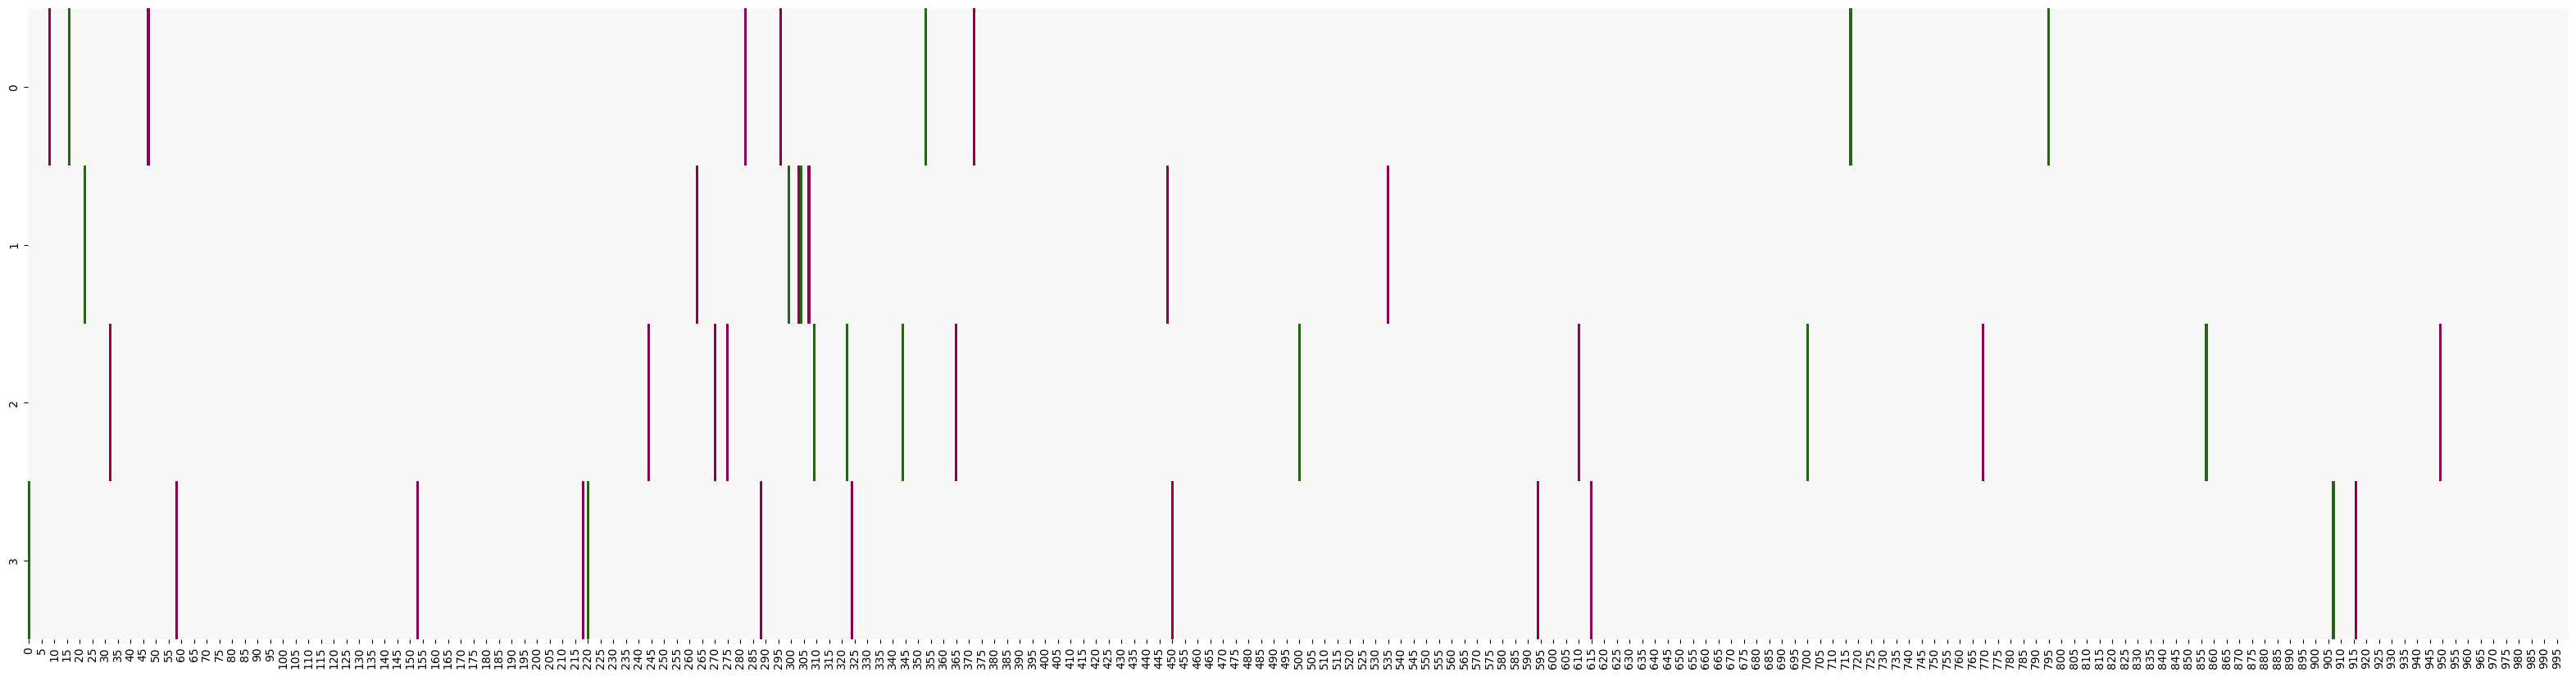

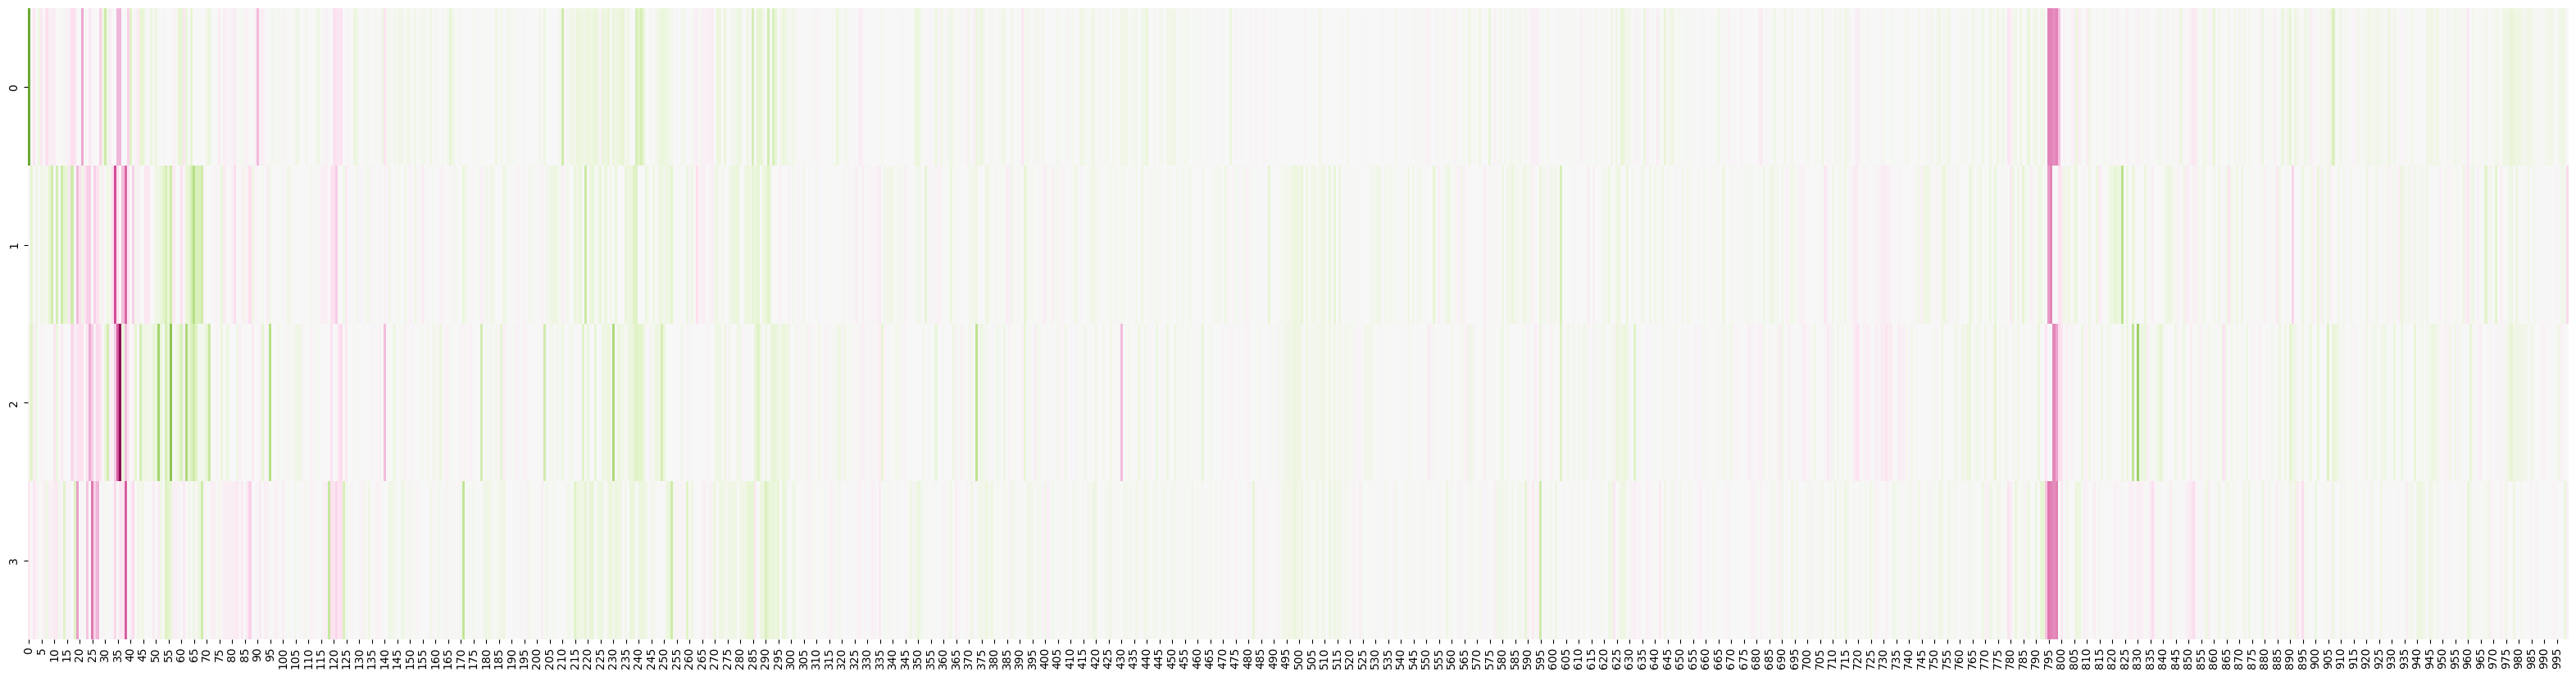

In [23]:
vis_row = n_variants_df.sort_values(by="n_variants_in_data", ascending=False).iloc[0]
vis_gene = vis_row["gene"]
vis_region_start = int(vis_row["region"].split(":")[0])
vis_region_end = int(vis_row["region"].split(":")[1])
vis_region_ism_scores = stats.zscore(all_ism_scores[vis_gene], axis=None)[
    vis_region_start:vis_region_end
]
vis_region_baseline_enformer_ism_scores = stats.zscore(
    all_baseline_enformer_ism_scores[vis_gene], axis=None
)[vis_region_start:vis_region_end]

vis_region_train_variants = all_train_variants[vis_gene][
    vis_region_start:vis_region_end
]
vis_region_test_val_exclusive_variants = all_test_val_exclusive_variants[vis_gene][
    vis_region_start:vis_region_end
]

vis_region_observed_variants = np.zeros(vis_region_train_variants.shape)
vis_region_observed_variants[vis_region_train_variants] = -1
vis_region_observed_variants[vis_region_test_val_exclusive_variants] = 1

plt.subplots(figsize=(4 * 10, 10))
sns.heatmap(data=vis_region_observed_variants.T, square=False, cbar=False, cmap="PiYG")
plt.show()
# plt.subplots(figsize=(4*10, 10))
# sns.heatmap(data=vis_region_ism_scores.T, square=True)
# plt.show()
# plt.subplots(figsize=(4*10, 10))
# sns.heatmap(data=vis_region_baseline_enformer_ism_scores.T, square=True)
# plt.show()
plt.subplots(figsize=(4 * 10, 10))
sns.heatmap(
    data=vis_region_ism_scores.T - vis_region_baseline_enformer_ism_scores.T,
    square=False,
    cmap="PiYG",
    center=0,
    cbar=False,
)
plt.show()

In [7]:
dist_to_closest_training_variants = {}
closest_training_variant_position = {}

for gene in tqdm(population_split_genes["gene"].unique()):
    positions_with_train_variants = np.arange(all_train_variants[gene].shape[0])[
        (all_train_variants[gene].sum(axis=-1) > 0)
    ]
    dist_to_closest_training_variants[gene] = np.full(
        all_train_variants[gene].shape[0], np.inf
    )
    dist_to_closest_training_variants[gene][positions_with_train_variants] = 0

    closest_training_variant_position[gene] = np.full(
        all_train_variants[gene].shape[0], -1
    )

    cur_pos = 0
    for i in range(all_train_variants[gene].shape[0]):
        if i == 0:
            closest_training_variant_position[gene][i] = positions_with_train_variants[
                cur_pos
            ]
            if i >= positions_with_train_variants[cur_pos]:
                cur_pos += 1
        elif cur_pos == len(positions_with_train_variants):
            closest_training_variant_position[gene][i] = positions_with_train_variants[
                cur_pos - 1
            ]
        else:
            if abs(positions_with_train_variants[cur_pos] - i) < abs(
                positions_with_train_variants[cur_pos - 1] - i
            ):
                closest_training_variant_position[gene][
                    i
                ] = positions_with_train_variants[cur_pos]
            else:
                closest_training_variant_position[gene][
                    i
                ] = positions_with_train_variants[cur_pos - 1]
            if i >= positions_with_train_variants[cur_pos]:
                cur_pos += 1

        dist_to_closest_training_variants[gene][i] = abs(
            closest_training_variant_position[gene][i] - i
        )

    assert cur_pos == len(positions_with_train_variants)
    assert not np.isinf(dist_to_closest_training_variants[gene].sum())

100%|██████████| 200/200 [00:12<00:00, 16.57it/s]


In [8]:
normalized_ism_score = {}
normalized_abs_ism_score = {}
normalized_baseline_enformer_ism_score = {}
normalized_baseline_enformer_abs_ism_score = {}
dist_to_closest_training_variant_position_for_each_set = {}
normalized_ism_score_for_closest_training_variant_position_for_each_set = {}
normalized_baseline_enformer_ism_score_for_closest_training_variant_position_for_each_set = (
    {}
)

for set_name in [
    "train_variants",
    "test_val_exclusive_variants",
    "other_variants_exclude_positions_with_variants",
]:
    normalized_ism_score[set_name] = {}
    normalized_abs_ism_score[set_name] = {}
    normalized_baseline_enformer_ism_score[set_name] = {}
    normalized_baseline_enformer_abs_ism_score[set_name] = {}
    dist_to_closest_training_variant_position_for_each_set[set_name] = {}
    normalized_ism_score_for_closest_training_variant_position_for_each_set[
        set_name
    ] = {}
    normalized_baseline_enformer_ism_score_for_closest_training_variant_position_for_each_set[
        set_name
    ] = {}

for gene in tqdm(population_split_genes["gene"].unique()):
    gene_ism_scores = all_ism_scores[gene]
    gene_abs_ism_scores = np.abs(gene_ism_scores)
    gene_baseline_enformer_ism_scores = all_baseline_enformer_ism_scores[gene]
    gene_baseline_enformer_abs_ism_scores = np.abs(gene_baseline_enformer_ism_scores)

    normalized_gene_ism_scores = stats.zscore(gene_ism_scores)
    normalized_gene_abs_ism_scores = stats.zscore(gene_abs_ism_scores)
    normalized_gene_baseline_enformer_ism_scores = stats.zscore(
        gene_baseline_enformer_ism_scores
    )
    normalized_gene_baseline_enformer_abs_ism_scores = stats.zscore(
        gene_baseline_enformer_abs_ism_scores
    )

    normalized_ism_score["train_variants"][gene] = normalized_gene_ism_scores[
        all_train_variants[gene]
    ]
    normalized_abs_ism_score["train_variants"][gene] = normalized_gene_abs_ism_scores[
        all_train_variants[gene]
    ]
    normalized_baseline_enformer_ism_score["train_variants"][
        gene
    ] = normalized_gene_baseline_enformer_ism_scores[all_train_variants[gene]]
    normalized_baseline_enformer_abs_ism_score["train_variants"][
        gene
    ] = normalized_gene_baseline_enformer_abs_ism_scores[all_train_variants[gene]]
    dist_to_closest_training_variant_position_for_each_set["train_variants"][
        gene
    ] = dist_to_closest_training_variants[gene][
        np.where(all_train_variants[gene] > 0)[0]
    ]
    assert (
        dist_to_closest_training_variant_position_for_each_set["train_variants"][
            gene
        ].sum()
        == 0
    )
    normalized_ism_score_for_closest_training_variant_position_for_each_set[
        "train_variants"
    ][gene] = normalized_gene_ism_scores[all_train_variants[gene]]
    normalized_baseline_enformer_ism_score_for_closest_training_variant_position_for_each_set[
        "train_variants"
    ][
        gene
    ] = normalized_gene_baseline_enformer_ism_scores[
        all_train_variants[gene]
    ]

    normalized_ism_score["test_val_exclusive_variants"][
        gene
    ] = normalized_gene_ism_scores[all_test_val_exclusive_variants[gene]]
    normalized_abs_ism_score["test_val_exclusive_variants"][
        gene
    ] = normalized_gene_abs_ism_scores[all_test_val_exclusive_variants[gene]]
    normalized_baseline_enformer_ism_score["test_val_exclusive_variants"][
        gene
    ] = normalized_gene_baseline_enformer_ism_scores[
        all_test_val_exclusive_variants[gene]
    ]
    normalized_baseline_enformer_abs_ism_score["test_val_exclusive_variants"][
        gene
    ] = normalized_gene_baseline_enformer_abs_ism_scores[
        all_test_val_exclusive_variants[gene]
    ]
    dist_to_closest_training_variant_position_for_each_set[
        "test_val_exclusive_variants"
    ][gene] = dist_to_closest_training_variants[gene][
        np.where(all_test_val_exclusive_variants[gene] > 0)[0]
    ]
    base = np.where(all_test_val_exclusive_variants[gene] > 0)[1]
    normalized_ism_score_for_closest_training_variant_position_for_each_set[
        "test_val_exclusive_variants"
    ][gene] = normalized_gene_ism_scores[
        closest_training_variant_position[gene][
            np.where(all_test_val_exclusive_variants[gene] > 0)[0]
        ],
        base,
    ]
    normalized_baseline_enformer_ism_score_for_closest_training_variant_position_for_each_set[
        "test_val_exclusive_variants"
    ][
        gene
    ] = normalized_gene_baseline_enformer_ism_scores[
        closest_training_variant_position[gene][
            np.where(all_test_val_exclusive_variants[gene] > 0)[0]
        ],
        base,
    ]

    normalized_ism_score["other_variants_exclude_positions_with_variants"][
        gene
    ] = normalized_gene_ism_scores[
        all_other_variants_exclude_positions_with_variants_in_data[gene]
    ]
    normalized_abs_ism_score["other_variants_exclude_positions_with_variants"][
        gene
    ] = normalized_gene_abs_ism_scores[
        all_other_variants_exclude_positions_with_variants_in_data[gene]
    ]
    normalized_baseline_enformer_ism_score[
        "other_variants_exclude_positions_with_variants"
    ][gene] = normalized_gene_baseline_enformer_ism_scores[
        all_other_variants_exclude_positions_with_variants_in_data[gene]
    ]
    normalized_baseline_enformer_abs_ism_score[
        "other_variants_exclude_positions_with_variants"
    ][gene] = normalized_gene_baseline_enformer_abs_ism_scores[
        all_other_variants_exclude_positions_with_variants_in_data[gene]
    ]
    dist_to_closest_training_variant_position_for_each_set[
        "other_variants_exclude_positions_with_variants"
    ][gene] = dist_to_closest_training_variants[gene][
        np.where(all_other_variants_exclude_positions_with_variants_in_data[gene] > 0)[
            0
        ]
    ]
    assert np.all(
        dist_to_closest_training_variant_position_for_each_set[
            "other_variants_exclude_positions_with_variants"
        ][gene]
        > 0
    )
    base = np.where(
        all_other_variants_exclude_positions_with_variants_in_data[gene] > 0
    )[1]
    normalized_ism_score_for_closest_training_variant_position_for_each_set[
        "other_variants_exclude_positions_with_variants"
    ][gene] = normalized_gene_ism_scores[
        closest_training_variant_position[gene][
            np.where(
                all_other_variants_exclude_positions_with_variants_in_data[gene] > 0
            )[0]
        ],
        base,
    ]
    normalized_baseline_enformer_ism_score_for_closest_training_variant_position_for_each_set[
        "other_variants_exclude_positions_with_variants"
    ][
        gene
    ] = normalized_gene_baseline_enformer_ism_scores[
        closest_training_variant_position[gene][
            np.where(
                all_other_variants_exclude_positions_with_variants_in_data[gene] > 0
            )[0]
        ],
        base,
    ]

100%|██████████| 200/200 [00:06<00:00, 29.08it/s]


In [9]:
# n_plot_genes = 25
# n_cols = 5
# subsample_unobserved = 1000
# unobserved_dist_thres = 100
# n_rows = int(np.ceil(n_plot_genes / n_cols))
# y_per_fig = 10
# x_per_fig = 8

# pop_split_genes = population_split_genes["gene"].unique()[:n_plot_genes]

# plot_df = {}
# plot_df["Gene"] = []
# plot_df["Variant Type"] = []
# plot_df["Variant AF"] = []
# plot_df["Distance to Closest Training Variant"] = []
# plot_df["Fine-tuned ISM"] = []
# plot_df["Baseline ISM"] = []
# plot_df["|Fine-tuned ISM|"] = []
# plot_df["|Baseline ISM|"] = []
# plot_df["|Fine-tuned ISM| - |Baseline ISM|"] = []
# plot_df["|Fine-tuned ISM - Baseline ISM|"] = []
# plot_df["Fine-tuned ISM - Baseline ISM"] = []

# print_set_names = {"test_val_exclusive_variants": "Test-val exclusive variants",
#                    "train_variants": "Variants seen during training",
#                    "other_variants_exclude_positions_with_variants": "Unobserved variants"}

# set_names = ["train_variants", "test_val_exclusive_variants", "other_variants_exclude_positions_with_variants"]
# print_set_names_order = [print_set_names[name] for name in set_names]

# for gene in tqdm(pop_split_genes):
#     for set_name in set_names:
#         if set_name == "other_variants_exclude_positions_with_variants":
#             plot_df["Gene"].extend([gene] * subsample_unobserved)
#             plot_df["Variant Type"].extend([print_set_names[set_name]] * subsample_unobserved)
#             plot_df["Variant AF"].extend([-1] * subsample_unobserved)

#             np.random.seed(97)
#             random_sample = np.random.choice(np.where(dist_to_closest_training_variant_position_for_each_set[set_name][gene] > unobserved_dist_thres)[0], subsample_unobserved, replace=False)
#             assert np.all(dist_to_closest_training_variant_position_for_each_set[set_name][gene][random_sample] > unobserved_dist_thres)
#             plot_df["Distance to Closest Training Variant"].extend(dist_to_closest_training_variant_position_for_each_set[set_name][gene][random_sample].tolist())
#             plot_df["Fine-tuned ISM"].extend(normalized_ism_score[set_name][gene][random_sample].tolist())
#             plot_df["Baseline ISM"].extend(normalized_baseline_enformer_ism_score[set_name][gene][random_sample].tolist())
#             plot_df["|Fine-tuned ISM|"].extend(normalized_abs_ism_score[set_name][gene][random_sample].tolist())
#             plot_df["|Baseline ISM|"].extend(normalized_baseline_enformer_abs_ism_score[set_name][gene][random_sample].tolist())

#             plot_df["|Fine-tuned ISM| - |Baseline ISM|"].extend((normalized_abs_ism_score[set_name][gene][random_sample] - normalized_baseline_enformer_abs_ism_score[set_name][gene][random_sample]).tolist())
#             plot_df["|Fine-tuned ISM - Baseline ISM|"].extend(np.abs(normalized_ism_score[set_name][gene][random_sample] - normalized_baseline_enformer_ism_score[set_name][gene][random_sample]).tolist())
#             plot_df["Fine-tuned ISM - Baseline ISM"].extend((normalized_ism_score[set_name][gene][random_sample] - normalized_baseline_enformer_ism_score[set_name][gene][random_sample]).tolist())
#         elif set_name == "train_variants":
#             plot_df["Gene"].extend([gene] * len(normalized_ism_score[set_name][gene]))
#             plot_df["Variant Type"].extend([print_set_names[set_name]] * len(normalized_ism_score[set_name][gene]))

#             plot_df["Distance to Closest Training Variant"].extend(dist_to_closest_training_variant_position_for_each_set[set_name][gene].tolist())
#             plot_df["Fine-tuned ISM"].extend(normalized_ism_score[set_name][gene].tolist())
#             plot_df["Baseline ISM"].extend(normalized_baseline_enformer_ism_score[set_name][gene].tolist())
#             plot_df["|Fine-tuned ISM|"].extend(normalized_abs_ism_score[set_name][gene].tolist())
#             plot_df["|Baseline ISM|"].extend(normalized_baseline_enformer_abs_ism_score[set_name][gene].tolist())

#             plot_df["|Fine-tuned ISM| - |Baseline ISM|"].extend((normalized_abs_ism_score[set_name][gene] - normalized_baseline_enformer_abs_ism_score[set_name][gene]).tolist())
#             plot_df["|Fine-tuned ISM - Baseline ISM|"].extend(np.abs(normalized_ism_score[set_name][gene] - normalized_baseline_enformer_ism_score[set_name][gene]).tolist())
#             plot_df["Fine-tuned ISM - Baseline ISM"].extend((normalized_ism_score[set_name][gene] - normalized_baseline_enformer_ism_score[set_name][gene]).tolist())

#             plot_df["Variant AF"].extend(all_train_variants_afs[gene].tolist())
#         else:
#             plot_df["Gene"].extend([gene] * len(normalized_ism_score[set_name][gene]))
#             plot_df["Variant Type"].extend([print_set_names[set_name]] * len(normalized_ism_score[set_name][gene]))
#             plot_df["Variant AF"].extend([-1] * len(normalized_ism_score[set_name][gene]))

#             plot_df["Distance to Closest Training Variant"].extend(dist_to_closest_training_variant_position_for_each_set[set_name][gene].tolist())
#             plot_df["Fine-tuned ISM"].extend(normalized_ism_score[set_name][gene].tolist())
#             plot_df["Baseline ISM"].extend(normalized_baseline_enformer_ism_score[set_name][gene].tolist())
#             plot_df["|Fine-tuned ISM|"].extend(normalized_abs_ism_score[set_name][gene].tolist())
#             plot_df["|Baseline ISM|"].extend(normalized_baseline_enformer_abs_ism_score[set_name][gene].tolist())

#             plot_df["|Fine-tuned ISM| - |Baseline ISM|"].extend((normalized_abs_ism_score[set_name][gene] - normalized_baseline_enformer_abs_ism_score[set_name][gene]).tolist())
#             plot_df["|Fine-tuned ISM - Baseline ISM|"].extend(np.abs(normalized_ism_score[set_name][gene] - normalized_baseline_enformer_ism_score[set_name][gene]).tolist())
#             plot_df["Fine-tuned ISM - Baseline ISM"].extend((normalized_ism_score[set_name][gene] - normalized_baseline_enformer_ism_score[set_name][gene]).tolist())

# plot_df = pd.DataFrame(plot_df)

# fig1, ax1 = plt.subplots(n_rows, n_cols*2, figsize=(x_per_fig*n_cols*2, y_per_fig*n_rows), constrained_layout=True) # "|Fine-tuned ISM| - |Baseline ISM|"
# fig2, ax2 = plt.subplots(n_rows, n_cols*2, figsize=(x_per_fig*n_cols*2, y_per_fig*n_rows), constrained_layout=True) # "|Fine-tuned ISM - Baseline ISM|"
# fig3, ax3 = plt.subplots(n_rows, n_cols*2, figsize=(x_per_fig*n_cols*2, y_per_fig*n_rows), constrained_layout=True) # "Fine-tuned ISM - Baseline ISM"

# fig4, ax4 = plt.subplots(n_rows, n_cols, figsize=(x_per_fig*n_cols, y_per_fig*n_rows), constrained_layout=True) # Fine-tuned ISM vs. Baseline ISM
# fig5, ax5 = plt.subplots(n_rows, n_cols, figsize=(x_per_fig*n_cols, y_per_fig*n_rows), constrained_layout=True) # |Fine-tuned ISM| vs. |Baseline ISM|

# cnt = 0
# for i in range(n_rows):
#     for j in range(n_cols):
#         gene = pop_split_genes[cnt]
#         gene_plot_df = plot_df[plot_df["Gene"] == gene].reset_index(drop=True)

#         title = f"{gene}\n("
#         for set_name in set_names:
#             title = title + f"{print_set_names[set_name]} = {(gene_plot_df['Variant Type'] == print_set_names[set_name]).sum()}, \n"
#         title = title[:-3] + ")"

#         sns.histplot(data=gene_plot_df, x="|Fine-tuned ISM| - |Baseline ISM|", hue="Variant Type", ax=ax1[i][j*2], hue_order=print_set_names_order)
#         ax1[i][j*2].set_title(title)
#         sns.violinplot(data=gene_plot_df, y="|Fine-tuned ISM| - |Baseline ISM|", x="Variant Type", ax=ax1[i][j*2 + 1])
#         ax1[i][j*2 + 1].set_title(title)

#         sns.histplot(data=gene_plot_df, x="|Fine-tuned ISM - Baseline ISM|", hue="Variant Type", ax=ax2[i][j*2], hue_order=print_set_names_order)
#         ax2[i][j*2].set_title(title)
#         sns.violinplot(data=gene_plot_df, y="|Fine-tuned ISM - Baseline ISM|", x="Variant Type", ax=ax2[i][j*2 + 1])
#         ax2[i][j*2 + 1].set_title(title)

#         sns.histplot(data=gene_plot_df, x="Fine-tuned ISM - Baseline ISM", hue="Variant Type", ax=ax3[i][j*2], hue_order=print_set_names_order)
#         ax3[i][j*2].set_title(title)
#         sns.violinplot(data=gene_plot_df, y="Fine-tuned ISM - Baseline ISM", x="Variant Type", ax=ax3[i][j*2 + 1])
#         ax3[i][j*2 + 1].set_title(title)

#         sns.scatterplot(data=gene_plot_df, x="Fine-tuned ISM", y="Baseline ISM", hue="Variant Type", ax=ax4[i][j], hue_order=print_set_names_order)
#         # add x=y line based on the min and max values of the data
#         min_val = min(gene_plot_df["Fine-tuned ISM"].min(), gene_plot_df["Baseline ISM"].min())
#         max_val = max(gene_plot_df["Fine-tuned ISM"].max(), gene_plot_df["Baseline ISM"].max())
#         ax4[i][j].plot([min_val, max_val], [min_val, max_val], "k--", alpha=0.5)
#         ax4[i][j].set_title(title)

#         sns.scatterplot(data=gene_plot_df, x="|Fine-tuned ISM|", y="|Baseline ISM|", hue="Variant Type", ax=ax5[i][j], hue_order=print_set_names_order)
#         # add x=y line based on the min and max values of the data
#         min_val = min(gene_plot_df["|Fine-tuned ISM|"].min(), gene_plot_df["|Baseline ISM|"].min())
#         max_val = max(gene_plot_df["|Fine-tuned ISM|"].max(), gene_plot_df["|Baseline ISM|"].max())
#         ax5[i][j].plot([min_val, max_val], [min_val, max_val], "k--", alpha=0.5)
#         ax5[i][j].set_title(title)

#         cnt += 1

# fig1.suptitle("|Fine-tuned ISM| - |Baseline ISM|")
# fig2.suptitle("|Fine-tuned ISM - Baseline ISM|")
# fig3.suptitle("Fine-tuned ISM - Baseline ISM")
# fig4.suptitle("Fine-tuned ISM vs. Baseline ISM")
# fig5.suptitle("|Fine-tuned ISM| vs. |Baseline ISM|")
# plt.show()

100%|██████████| 200/200 [00:11<00:00, 16.96it/s]


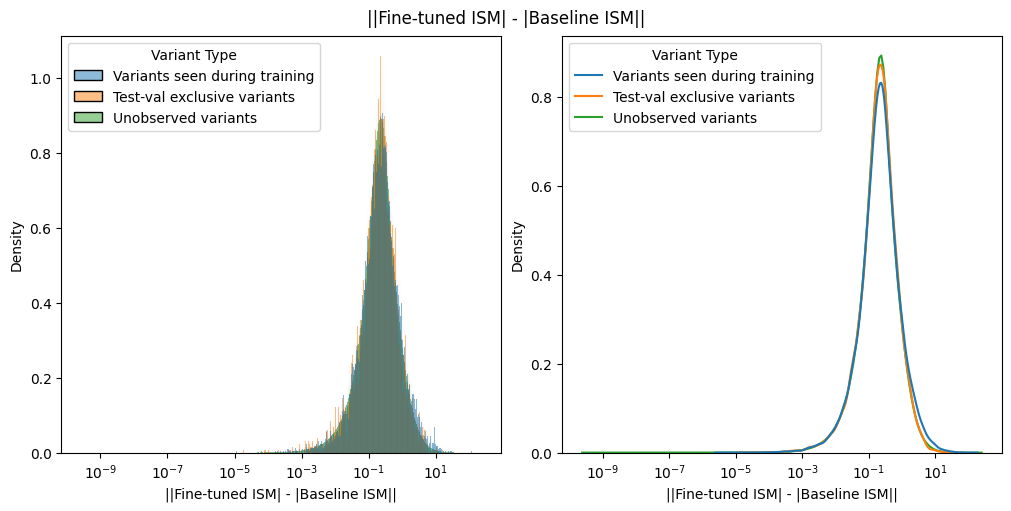

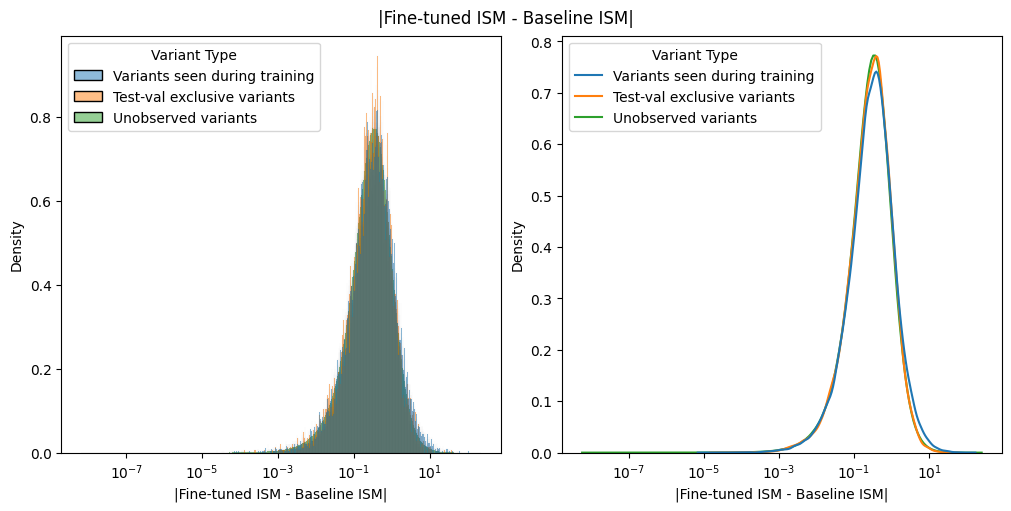

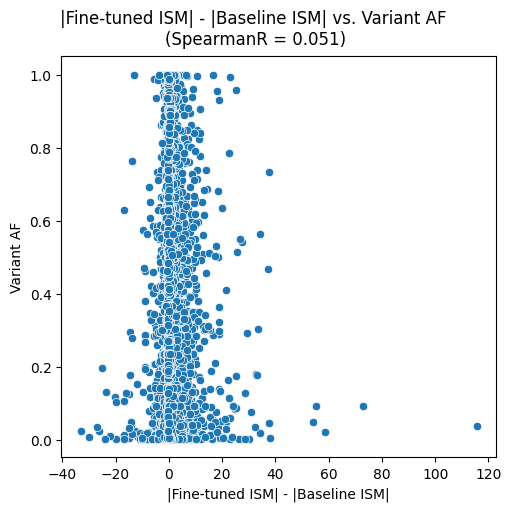

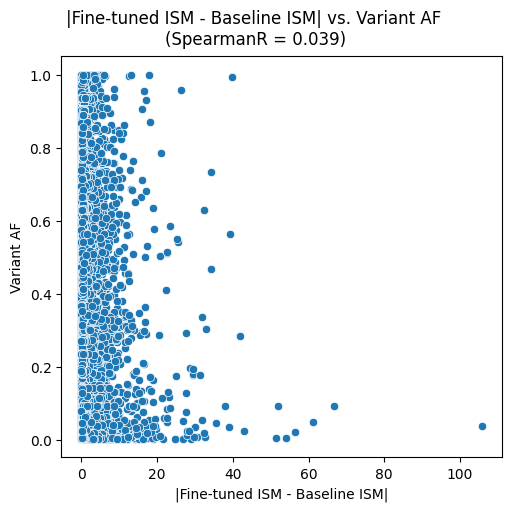

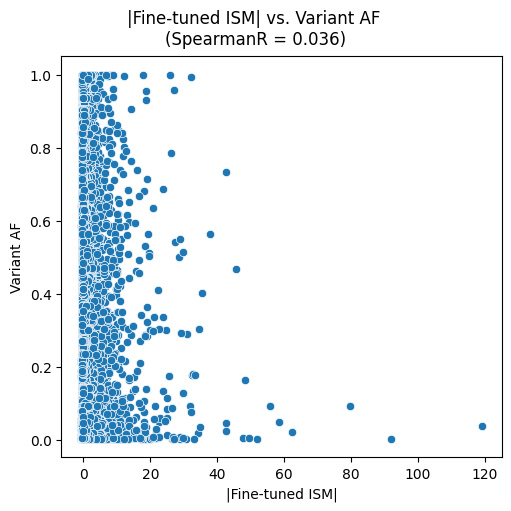

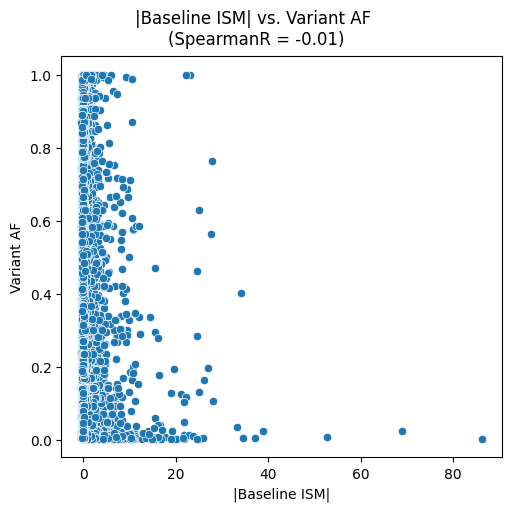

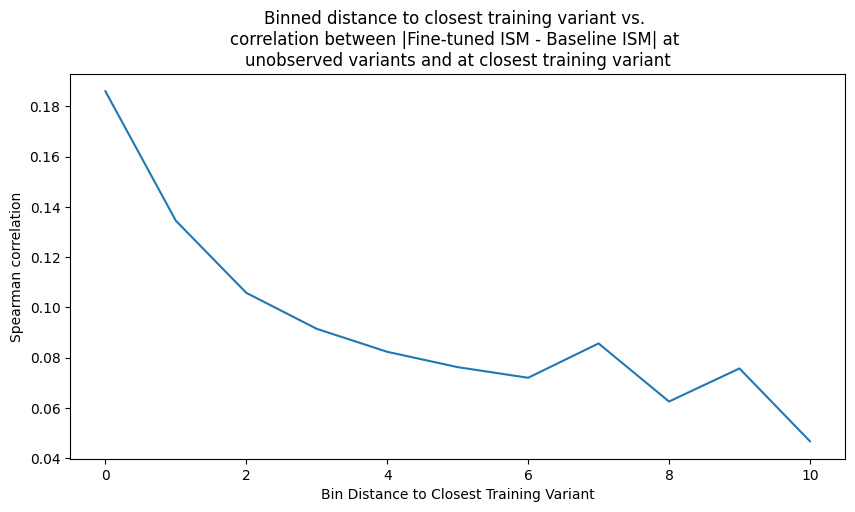

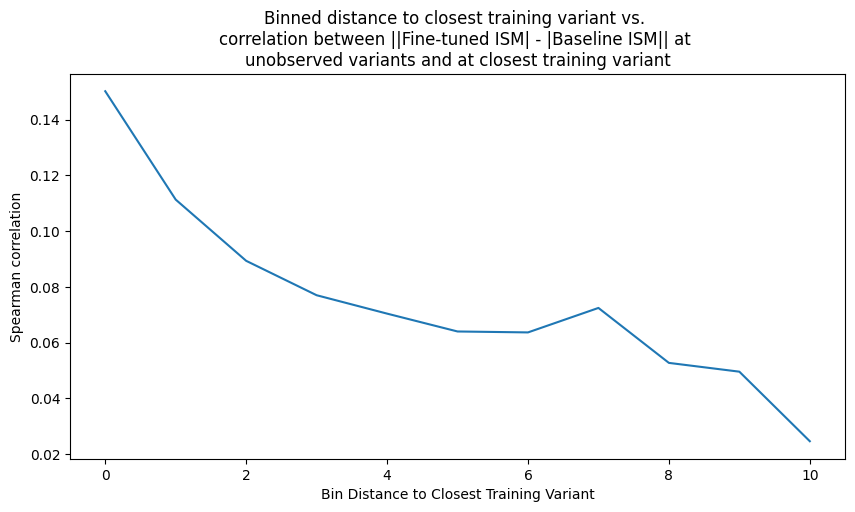

In [80]:
subsample_unobserved = -1
unobserved_dist_thres = 0
pop_split_genes = population_split_genes["gene"].unique()

plot_df = {}
plot_df["Gene"] = []
plot_df["Variant Type"] = []
plot_df["Variant AF"] = []

plot_df["Distance to Closest Training Variant"] = []
plot_df["Fine-tuned ISM at Closest Training Variant"] = []
plot_df["Baseline ISM at Closest Training Variant"] = []
plot_df["|Fine-tuned ISM - Baseline ISM| at Closest Training Variant"] = []
plot_df["|Fine-tuned ISM| - |Baseline ISM| at Closest Training Variant"] = []

plot_df["Fine-tuned ISM"] = []
plot_df["Baseline ISM"] = []
plot_df["|Fine-tuned ISM|"] = []
plot_df["|Baseline ISM|"] = []

plot_df["|Fine-tuned ISM| - |Baseline ISM|"] = []
plot_df["|Fine-tuned ISM - Baseline ISM|"] = []
plot_df["Fine-tuned ISM - Baseline ISM"] = []

print_set_names = {
    "test_val_exclusive_variants": "Test-val exclusive variants",
    "train_variants": "Variants seen during training",
    "other_variants_exclude_positions_with_variants": "Unobserved variants",
}

set_names = [
    "train_variants",
    "test_val_exclusive_variants",
    "other_variants_exclude_positions_with_variants",
]
print_set_names_order = [print_set_names[name] for name in set_names]

for gene in tqdm(pop_split_genes):
    for set_name in set_names:
        if (
            set_name == "other_variants_exclude_positions_with_variants"
            and subsample_unobserved != -1
        ):
            np.random.seed(97)
            if (
                len(
                    np.where(
                        dist_to_closest_training_variant_position_for_each_set[
                            set_name
                        ][gene]
                        > unobserved_dist_thres
                    )[0]
                )
                == 0
            ):
                print(
                    f"Skipping other_variants_exclude_positions_with_variants for {gene}"
                )
                continue

            plot_df["Gene"].extend([gene] * subsample_unobserved)
            plot_df["Variant Type"].extend(
                [print_set_names[set_name]] * subsample_unobserved
            )
            plot_df["Variant AF"].extend([-1] * subsample_unobserved)

            random_sample = np.random.choice(
                np.where(
                    dist_to_closest_training_variant_position_for_each_set[set_name][
                        gene
                    ]
                    > unobserved_dist_thres
                )[0],
                subsample_unobserved,
                replace=False,
            )
            assert np.all(
                dist_to_closest_training_variant_position_for_each_set[set_name][gene][
                    random_sample
                ]
                > unobserved_dist_thres
            )

            plot_df["Distance to Closest Training Variant"].extend(
                dist_to_closest_training_variant_position_for_each_set[set_name][gene][
                    random_sample
                ].tolist()
            )
            plot_df["Fine-tuned ISM at Closest Training Variant"].extend(
                normalized_ism_score_for_closest_training_variant_position_for_each_set[
                    set_name
                ][gene][random_sample].tolist()
            )
            plot_df["Baseline ISM at Closest Training Variant"].extend(
                normalized_baseline_enformer_ism_score_for_closest_training_variant_position_for_each_set[
                    set_name
                ][
                    gene
                ][
                    random_sample
                ].tolist()
            )
            plot_df[
                "|Fine-tuned ISM - Baseline ISM| at Closest Training Variant"
            ].extend(
                np.abs(
                    normalized_ism_score_for_closest_training_variant_position_for_each_set[
                        set_name
                    ][
                        gene
                    ][
                        random_sample
                    ]
                    - normalized_baseline_enformer_ism_score_for_closest_training_variant_position_for_each_set[
                        set_name
                    ][
                        gene
                    ][
                        random_sample
                    ]
                ).tolist()
            )
            plot_df[
                "|Fine-tuned ISM| - |Baseline ISM| at Closest Training Variant"
            ].extend(
                (
                    np.abs(
                        normalized_ism_score_for_closest_training_variant_position_for_each_set[
                            set_name
                        ][
                            gene
                        ][
                            random_sample
                        ]
                    )
                    - np.abs(
                        normalized_baseline_enformer_ism_score_for_closest_training_variant_position_for_each_set[
                            set_name
                        ][
                            gene
                        ][
                            random_sample
                        ]
                    )
                ).tolist()
            )

            plot_df["Fine-tuned ISM"].extend(
                normalized_ism_score[set_name][gene][random_sample].tolist()
            )
            plot_df["Baseline ISM"].extend(
                normalized_baseline_enformer_ism_score[set_name][gene][
                    random_sample
                ].tolist()
            )
            plot_df["|Fine-tuned ISM|"].extend(
                normalized_abs_ism_score[set_name][gene][random_sample].tolist()
            )
            plot_df["|Baseline ISM|"].extend(
                normalized_baseline_enformer_abs_ism_score[set_name][gene][
                    random_sample
                ].tolist()
            )

            plot_df["|Fine-tuned ISM| - |Baseline ISM|"].extend(
                (
                    normalized_abs_ism_score[set_name][gene][random_sample]
                    - normalized_baseline_enformer_abs_ism_score[set_name][gene][
                        random_sample
                    ]
                ).tolist()
            )
            plot_df["|Fine-tuned ISM - Baseline ISM|"].extend(
                np.abs(
                    normalized_ism_score[set_name][gene][random_sample]
                    - normalized_baseline_enformer_ism_score[set_name][gene][
                        random_sample
                    ]
                ).tolist()
            )
            plot_df["Fine-tuned ISM - Baseline ISM"].extend(
                (
                    normalized_ism_score[set_name][gene][random_sample]
                    - normalized_baseline_enformer_ism_score[set_name][gene][
                        random_sample
                    ]
                ).tolist()
            )
        elif set_name == "train_variants":
            plot_df["Gene"].extend([gene] * len(normalized_ism_score[set_name][gene]))
            plot_df["Variant Type"].extend(
                [print_set_names[set_name]] * len(normalized_ism_score[set_name][gene])
            )

            plot_df["Distance to Closest Training Variant"].extend(
                dist_to_closest_training_variant_position_for_each_set[set_name][
                    gene
                ].tolist()
            )
            plot_df["Fine-tuned ISM at Closest Training Variant"].extend(
                normalized_ism_score_for_closest_training_variant_position_for_each_set[
                    set_name
                ][gene].tolist()
            )
            plot_df["Baseline ISM at Closest Training Variant"].extend(
                normalized_baseline_enformer_ism_score_for_closest_training_variant_position_for_each_set[
                    set_name
                ][
                    gene
                ].tolist()
            )
            plot_df[
                "|Fine-tuned ISM - Baseline ISM| at Closest Training Variant"
            ].extend(
                np.abs(
                    normalized_ism_score_for_closest_training_variant_position_for_each_set[
                        set_name
                    ][
                        gene
                    ]
                    - normalized_baseline_enformer_ism_score_for_closest_training_variant_position_for_each_set[
                        set_name
                    ][
                        gene
                    ]
                ).tolist()
            )
            plot_df[
                "|Fine-tuned ISM| - |Baseline ISM| at Closest Training Variant"
            ].extend(
                (
                    np.abs(
                        normalized_ism_score_for_closest_training_variant_position_for_each_set[
                            set_name
                        ][
                            gene
                        ]
                    )
                    - np.abs(
                        normalized_baseline_enformer_ism_score_for_closest_training_variant_position_for_each_set[
                            set_name
                        ][
                            gene
                        ]
                    )
                ).tolist()
            )

            plot_df["Fine-tuned ISM"].extend(
                normalized_ism_score[set_name][gene].tolist()
            )
            plot_df["Baseline ISM"].extend(
                normalized_baseline_enformer_ism_score[set_name][gene].tolist()
            )
            plot_df["|Fine-tuned ISM|"].extend(
                normalized_abs_ism_score[set_name][gene].tolist()
            )
            plot_df["|Baseline ISM|"].extend(
                normalized_baseline_enformer_abs_ism_score[set_name][gene].tolist()
            )

            plot_df["|Fine-tuned ISM| - |Baseline ISM|"].extend(
                (
                    normalized_abs_ism_score[set_name][gene]
                    - normalized_baseline_enformer_abs_ism_score[set_name][gene]
                ).tolist()
            )
            plot_df["|Fine-tuned ISM - Baseline ISM|"].extend(
                np.abs(
                    normalized_ism_score[set_name][gene]
                    - normalized_baseline_enformer_ism_score[set_name][gene]
                ).tolist()
            )
            plot_df["Fine-tuned ISM - Baseline ISM"].extend(
                (
                    normalized_ism_score[set_name][gene]
                    - normalized_baseline_enformer_ism_score[set_name][gene]
                ).tolist()
            )

            plot_df["Variant AF"].extend(all_train_variants_afs[gene].tolist())
        else:
            plot_df["Gene"].extend([gene] * len(normalized_ism_score[set_name][gene]))
            plot_df["Variant Type"].extend(
                [print_set_names[set_name]] * len(normalized_ism_score[set_name][gene])
            )
            plot_df["Variant AF"].extend(
                [-1] * len(normalized_ism_score[set_name][gene])
            )

            plot_df["Distance to Closest Training Variant"].extend(
                dist_to_closest_training_variant_position_for_each_set[set_name][
                    gene
                ].tolist()
            )
            plot_df["Fine-tuned ISM at Closest Training Variant"].extend(
                normalized_ism_score_for_closest_training_variant_position_for_each_set[
                    set_name
                ][gene].tolist()
            )
            plot_df["Baseline ISM at Closest Training Variant"].extend(
                normalized_baseline_enformer_ism_score_for_closest_training_variant_position_for_each_set[
                    set_name
                ][
                    gene
                ].tolist()
            )
            plot_df[
                "|Fine-tuned ISM - Baseline ISM| at Closest Training Variant"
            ].extend(
                np.abs(
                    normalized_ism_score_for_closest_training_variant_position_for_each_set[
                        set_name
                    ][
                        gene
                    ]
                    - normalized_baseline_enformer_ism_score_for_closest_training_variant_position_for_each_set[
                        set_name
                    ][
                        gene
                    ]
                ).tolist()
            )
            plot_df[
                "|Fine-tuned ISM| - |Baseline ISM| at Closest Training Variant"
            ].extend(
                (
                    np.abs(
                        normalized_ism_score_for_closest_training_variant_position_for_each_set[
                            set_name
                        ][
                            gene
                        ]
                    )
                    - np.abs(
                        normalized_baseline_enformer_ism_score_for_closest_training_variant_position_for_each_set[
                            set_name
                        ][
                            gene
                        ]
                    )
                ).tolist()
            )

            plot_df["Fine-tuned ISM"].extend(
                normalized_ism_score[set_name][gene].tolist()
            )
            plot_df["Baseline ISM"].extend(
                normalized_baseline_enformer_ism_score[set_name][gene].tolist()
            )
            plot_df["|Fine-tuned ISM|"].extend(
                normalized_abs_ism_score[set_name][gene].tolist()
            )
            plot_df["|Baseline ISM|"].extend(
                normalized_baseline_enformer_abs_ism_score[set_name][gene].tolist()
            )

            plot_df["|Fine-tuned ISM| - |Baseline ISM|"].extend(
                (
                    normalized_abs_ism_score[set_name][gene]
                    - normalized_baseline_enformer_abs_ism_score[set_name][gene]
                ).tolist()
            )
            plot_df["|Fine-tuned ISM - Baseline ISM|"].extend(
                np.abs(
                    normalized_ism_score[set_name][gene]
                    - normalized_baseline_enformer_ism_score[set_name][gene]
                ).tolist()
            )
            plot_df["Fine-tuned ISM - Baseline ISM"].extend(
                (
                    normalized_ism_score[set_name][gene]
                    - normalized_baseline_enformer_ism_score[set_name][gene]
                ).tolist()
            )

plot_df = pd.DataFrame(plot_df)
plot_df["||Fine-tuned ISM| - |Baseline ISM||"] = np.abs(
    plot_df["|Fine-tuned ISM| - |Baseline ISM|"]
)
plot_df["||Fine-tuned ISM| - |Baseline ISM|| at Closest Training Variant"] = np.abs(
    plot_df["|Fine-tuned ISM| - |Baseline ISM| at Closest Training Variant"]
)
# plot_df["Distance to Closest Training Variant"] = np.log10(plot_df["Distance to Closest Training Variant"] + 1)

fig1, ax1 = plt.subplots(
    1, 2, figsize=(10, 5), constrained_layout=True
)  # "||Fine-tuned ISM| - |Baseline ISM||"
sns.histplot(
    data=plot_df,
    x="||Fine-tuned ISM| - |Baseline ISM||",
    stat="density",
    hue="Variant Type",
    ax=ax1[0],
    hue_order=print_set_names_order,
    log_scale=True,
    common_norm=False,
)
sns.kdeplot(
    data=plot_df,
    x="||Fine-tuned ISM| - |Baseline ISM||",
    hue="Variant Type",
    ax=ax1[1],
    hue_order=print_set_names_order,
    log_scale=True,
    common_norm=False,
)
fig1.suptitle("||Fine-tuned ISM| - |Baseline ISM||")
plt.show()

fig2, ax2 = plt.subplots(
    1, 2, figsize=(10, 5), constrained_layout=True
)  # "|Fine-tuned ISM - Baseline ISM|"
sns.histplot(
    data=plot_df,
    x="|Fine-tuned ISM - Baseline ISM|",
    stat="density",
    hue="Variant Type",
    ax=ax2[0],
    hue_order=print_set_names_order,
    log_scale=True,
    common_norm=False,
)
sns.kdeplot(
    data=plot_df,
    x="|Fine-tuned ISM - Baseline ISM|",
    hue="Variant Type",
    ax=ax2[1],
    hue_order=print_set_names_order,
    log_scale=True,
    common_norm=False,
)
fig2.suptitle("|Fine-tuned ISM - Baseline ISM|")
plt.show()

# fig3, ax3 = plt.subplots(1, len(print_set_names_order), figsize=(5*len(print_set_names_order), 5), constrained_layout=True) # Fine-tuned ISM vs. Baseline ISM
# x = "Fine-tuned ISM"
# y = "Baseline ISM"
# for i, variant_type in enumerate(print_set_names_order):
#     variant_df = plot_df[plot_df["Variant Type"] == variant_type].reset_index(drop=True)
#     sns.scatterplot(data=variant_df, x=x, y=y, ax=ax3[i],
#                     hue="Distance to Closest Training Variant", size="Distance to Closest Training Variant")
#     p = sns.regplot(data=variant_df, x=x, y=y, ax=ax3[i], scatter=False)
#     # ax3[i].set_xscale("log")
#     # ax3[i].set_yscale("log")
#     min_val = min(variant_df[x].min(), variant_df[y].min())
#     max_val = max(variant_df[x].max(), variant_df[y].max())
#     ax3[i].plot([min_val, max_val], [min_val, max_val], "r--", label="x=y", alpha=0.5)

#     #calculate slope and intercept of regression equation
#     slope, intercept, r, p, sterr = stats.linregress(x=p.get_lines()[0].get_xdata(),
#                                                            y=p.get_lines()[0].get_ydata())

#     #add regression equation to plot
#     ax3[i].set_title(variant_type + '\n(y = ' + str(round(intercept,3)) + ' + ' + str(round(slope,3)) + 'x)')
#     ax3[i].legend()

# fig3.suptitle(f"{x} vs. {y}")
# plt.show()

# fig3, ax3 = plt.subplots(1, len(print_set_names_order), figsize=(5*len(print_set_names_order), 5), constrained_layout=True) # Fine-tuned ISM vs. Baseline ISM
# x = "|Fine-tuned ISM|"
# y = "|Baseline ISM|"
# for i, variant_type in enumerate(print_set_names_order):
#     variant_df = plot_df[plot_df["Variant Type"] == variant_type].reset_index(drop=True)
#     sns.scatterplot(data=variant_df, x=x, y=y, ax=ax3[i],
#                     hue="Distance to Closest Training Variant", size="Distance to Closest Training Variant")
#     p = sns.regplot(data=variant_df, x=x, y=y, ax=ax3[i], scatter=False)
#     # ax3[i].set_xscale("log")
#     # ax3[i].set_yscale("log")
#     min_val = min(variant_df[x].min(), variant_df[y].min())
#     max_val = max(variant_df[x].max(), variant_df[y].max())
#     ax3[i].plot([min_val, max_val], [min_val, max_val], "r--", label="x=y", alpha=0.5)

#     #calculate slope and intercept of regression equation
#     slope, intercept, r, p, sterr = stats.linregress(x=p.get_lines()[0].get_xdata(),
#                                                            y=p.get_lines()[0].get_ydata())

#     #add regression equation to plot
#     ax3[i].set_title(variant_type + '\n(y = ' + str(round(intercept,3)) + ' + ' + str(round(slope,3)) + 'x)')
#     ax3[i].legend()

# fig3.suptitle(f"{x} vs. {y}")
# plt.show()


x = "|Fine-tuned ISM| - |Baseline ISM|"
y = "Variant AF"
fig6, ax6 = plt.subplots(
    figsize=(5, 5), constrained_layout=True
)  # |Fine-tuned ISM| - |Baseline ISM| vs. Variant AF
variant_type = "Variants seen during training"
variant_df = plot_df[plot_df["Variant Type"] == variant_type].reset_index(drop=True)
sns.scatterplot(data=variant_df, x=x, y=y, ax=ax6)
corr = spearmanr(variant_df[x], variant_df[y])[0].round(3)
fig6.suptitle(f"{x} vs. {y} \n(SpearmanR = {corr})")
plt.show()

x = "|Fine-tuned ISM - Baseline ISM|"
y = "Variant AF"
fig6, ax6 = plt.subplots(
    figsize=(5, 5), constrained_layout=True
)  # |Fine-tuned ISM| - |Baseline ISM| vs. Variant AF
variant_type = "Variants seen during training"
variant_df = plot_df[plot_df["Variant Type"] == variant_type].reset_index(drop=True)
sns.scatterplot(data=variant_df, x=x, y=y, ax=ax6)
corr = spearmanr(variant_df[x], variant_df[y])[0].round(3)
fig6.suptitle(f"{x} vs. {y} \n(SpearmanR = {corr})")
plt.show()

x = "|Fine-tuned ISM|"
y = "Variant AF"
fig6, ax6 = plt.subplots(
    figsize=(5, 5), constrained_layout=True
)  # |Fine-tuned ISM| - |Baseline ISM| vs. Variant AF
variant_type = "Variants seen during training"
variant_df = plot_df[plot_df["Variant Type"] == variant_type].reset_index(drop=True)
sns.scatterplot(data=variant_df, x=x, y=y, ax=ax6)
corr = spearmanr(variant_df[x], variant_df[y])[0].round(3)
fig6.suptitle(f"{x} vs. {y} \n(SpearmanR = {corr})")
plt.show()

x = "|Baseline ISM|"
y = "Variant AF"
fig6, ax6 = plt.subplots(
    figsize=(5, 5), constrained_layout=True
)  # |Fine-tuned ISM| - |Baseline ISM| vs. Variant AF
variant_type = "Variants seen during training"
variant_df = plot_df[plot_df["Variant Type"] == variant_type].reset_index(drop=True)
sns.scatterplot(data=variant_df, x=x, y=y, ax=ax6)
corr = spearmanr(variant_df[x], variant_df[y])[0].round(3)
fig6.suptitle(f"{x} vs. {y} \n(SpearmanR = {corr})")
plt.show()


x = "|Fine-tuned ISM - Baseline ISM|"
y = "|Fine-tuned ISM - Baseline ISM| at Closest Training Variant"
bin_var = "Distance to Closest Training Variant"
variant_type = "Unobserved variants"
variant_df = plot_df[plot_df["Variant Type"] == variant_type].reset_index(drop=True)
variant_df[f"Binned {bin_var}"] = variant_df[bin_var] // 100
variant_df.loc[variant_df[f"Binned {bin_var}"] > 10, f"Binned {bin_var}"] = 10
temp_df = {}
temp_df[f"Bin {bin_var}"] = []
temp_df[f"Num variants"] = []
temp_df[f"Spearman correlation"] = []
temp_df[f"Pearson correlation"] = []

for bin, bin_df in variant_df.groupby(f"Binned {bin_var}"):
    temp_df[f"Bin {bin_var}"].append(bin)
    temp_df[f"Num variants"].append(bin_df.shape[0])
    temp_df[f"Spearman correlation"].append(spearmanr(bin_df[x], bin_df[y])[0])
    temp_df[f"Pearson correlation"].append(pearsonr(bin_df[x], bin_df[y])[0])

temp_df = pd.DataFrame(temp_df)
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=temp_df, x=f"Bin {bin_var}", y="Spearman correlation", ax=ax)
ax.set_title(
    f"Binned {bin_var.lower()} vs. \ncorrelation between {x} at \n{variant_type.lower()} and at closest training variant"
)
plt.show()


x = "||Fine-tuned ISM| - |Baseline ISM||"
y = "||Fine-tuned ISM| - |Baseline ISM|| at Closest Training Variant"
bin_var = "Distance to Closest Training Variant"
variant_type = "Unobserved variants"
variant_df = plot_df[plot_df["Variant Type"] == variant_type].reset_index(drop=True)
variant_df[f"Binned {bin_var}"] = variant_df[bin_var] // 100
variant_df.loc[variant_df[f"Binned {bin_var}"] > 10, f"Binned {bin_var}"] = 10
temp_df = {}
temp_df[f"Bin {bin_var}"] = []
temp_df[f"Num variants"] = []
temp_df[f"Spearman correlation"] = []
temp_df[f"Pearson correlation"] = []

for bin, bin_df in variant_df.groupby(f"Binned {bin_var}"):
    temp_df[f"Bin {bin_var}"].append(bin)
    temp_df[f"Num variants"].append(bin_df.shape[0])
    temp_df[f"Spearman correlation"].append(spearmanr(bin_df[x], bin_df[y])[0])
    temp_df[f"Pearson correlation"].append(pearsonr(bin_df[x], bin_df[y])[0])

temp_df = pd.DataFrame(temp_df)
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=temp_df, x=f"Bin {bin_var}", y="Spearman correlation", ax=ax)
ax.set_title(
    f"Binned {bin_var.lower()} vs. \ncorrelation between {x} at \n{variant_type.lower()} and at closest training variant"
)
plt.show()


# x = "|Fine-tuned ISM - Baseline ISM|"
# y = "Distance to Closest Training Variant"
# fig6, ax6 = plt.subplots(figsize=(15, 5), constrained_layout=True) # |Fine-tuned ISM| - |Baseline ISM| vs. Variant AF
# variant_type = "Unobserved variants"
# variant_df = plot_df[plot_df["Variant Type"] == variant_type].reset_index(drop=True)
# variant_df[f"Binned {y}"] = variant_df[y] // 1000
# sns.stripplot(data=variant_df, y="|Fine-tuned ISM - Baseline ISM|", x=f"Binned {y}", ax=ax6)
# fig6.suptitle(f"{x} vs. {y}")
# plt.show()


# x = "|Fine-tuned ISM - Baseline ISM|"
# y = "Distance to Closest Training Variant"
# fig6, ax6 = plt.subplots(figsize=(5, 5), constrained_layout=True) # |Fine-tuned ISM| - |Baseline ISM| vs. Variant AF
# variant_type = "Unobserved variants"
# variant_df = plot_df[plot_df["Variant Type"] == variant_type].reset_index(drop=True)
# variant_df[f"Binned {y}"] = variant_df[y] // 10000
# sns.stripplot(data=variant_df, y="|Fine-tuned ISM - Baseline ISM|", hue=f"Binned {y}", ax=ax6)
# ax6.set_yscale("log")
# fig6.suptitle(f"{x} vs. {y}")
# plt.show()


# x = "|Fine-tuned ISM - Baseline ISM|"
# y = "Distance to Closest Training Variant"
# fig6, ax6 = plt.subplots(figsize=(5, 5), constrained_layout=True) # |Fine-tuned ISM| - |Baseline ISM| vs. Variant AF
# variant_type = "Unobserved variants"
# variant_df = plot_df[plot_df["Variant Type"] == variant_type].reset_index(drop=True)
# sns.scatterplot(data=variant_df, x=x, y=y, ax=ax6)
# corr = spearmanr(variant_df[x], variant_df[y])[0].round(3)
# fig6.suptitle(f"{x} vs. {y} \n(SpearmanR = {corr})")
# plt.show()

# x = "|Fine-tuned ISM|"
# y = "Distance to Closest Training Variant"
# fig6, ax6 = plt.subplots(figsize=(5, 5), constrained_layout=True) # |Fine-tuned ISM| - |Baseline ISM| vs. Variant AF
# variant_type = "Unobserved variants"
# variant_df = plot_df[plot_df["Variant Type"] == variant_type].reset_index(drop=True)
# sns.scatterplot(data=variant_df, x=x, y=y, ax=ax6)
# corr = spearmanr(variant_df[x], variant_df[y])[0].round(3)
# fig6.suptitle(f"{x} vs. {y} \n(SpearmanR = {corr})")
# plt.show()

# x = "|Baseline ISM|"
# y = "Distance to Closest Training Variant"
# fig6, ax6 = plt.subplots(figsize=(5, 5), constrained_layout=True) # |Fine-tuned ISM| - |Baseline ISM| vs. Variant AF
# variant_type = "Unobserved variants"
# variant_df = plot_df[plot_df["Variant Type"] == variant_type].reset_index(drop=True)
# sns.scatterplot(data=variant_df, x=x, y=y, ax=ax6)
# corr = spearmanr(variant_df[x], variant_df[y])[0].round(3)
# fig6.suptitle(f"{x} vs. {y} \n(SpearmanR = {corr})")
# plt.show()

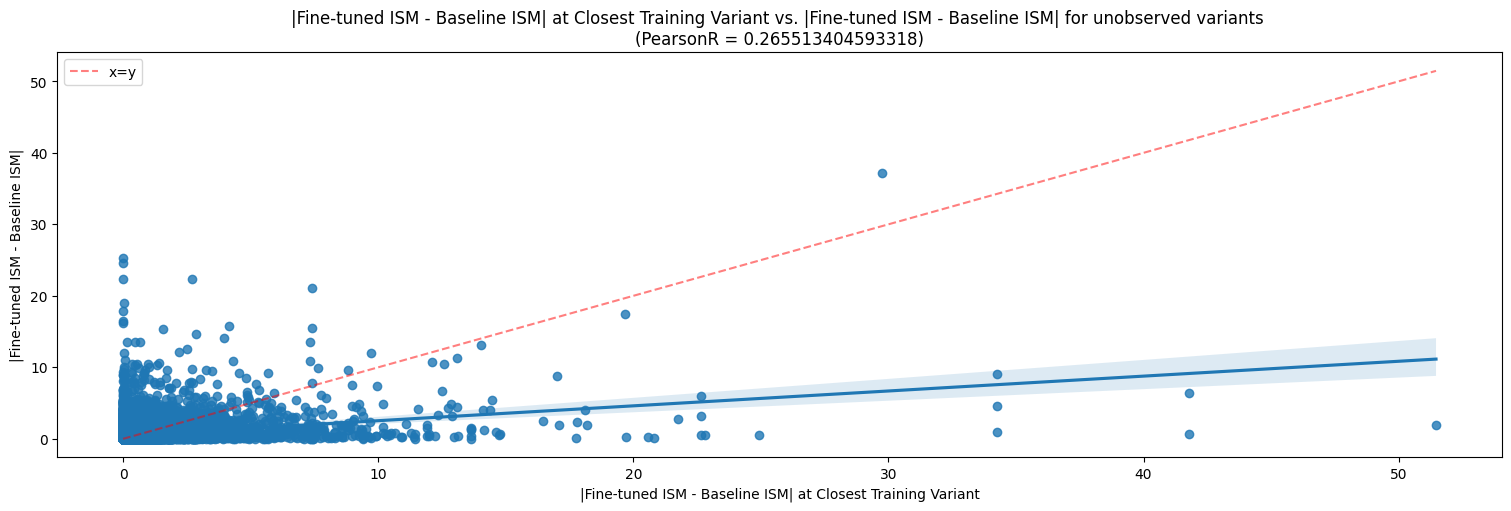

In [120]:
x = "|Fine-tuned ISM - Baseline ISM| at Closest Training Variant"
y = "|Fine-tuned ISM - Baseline ISM|"
variant_type = "Test-val exclusive variants"
variant_df = plot_df[plot_df["Variant Type"] == variant_type].reset_index(drop=True)
variant_df[f"Binned Distance to Closest Training Variant"] = (
    variant_df["Distance to Closest Training Variant"] // 1000
)

fig6, ax6 = plt.subplots(figsize=(15, 5), constrained_layout=True)
sns.regplot(data=variant_df, x=x, y=y, ax=ax6)
min_val = min(variant_df[x].min(), variant_df[y].min())
max_val = max(variant_df[x].max(), variant_df[y].max())
ax6.plot([min_val, max_val], [min_val, max_val], "r--", label="x=y", alpha=0.5)
ax6.set_title(
    f"{x} vs. {y} for unobserved variants \n(PearsonR = {pearsonr(variant_df[x], variant_df[y])[0]})"
)
ax6.legend()

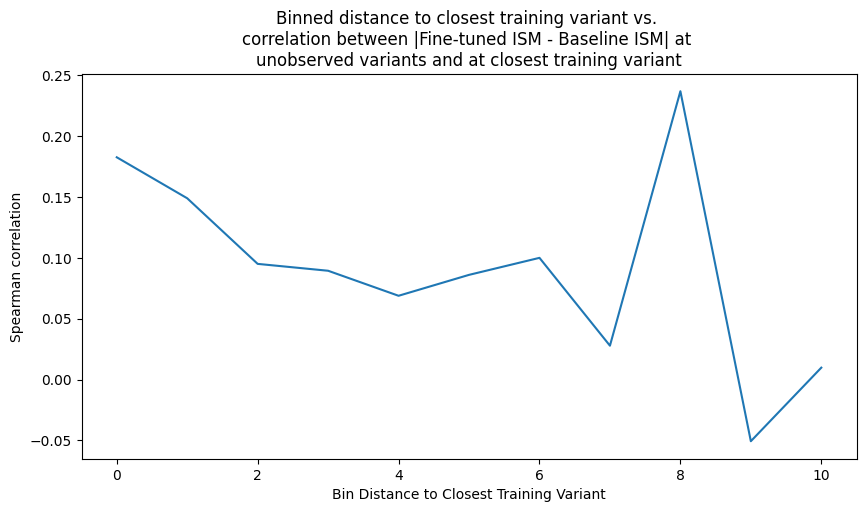

,Bin Distance to Closest Training Variant,Num variants,Spearman correlation,Pearson correlation
0,0.0,61933,0.182690,0.234827
1,1.0,21194,0.148998,0.192772
2,2.0,8026,0.095080,0.112126
3,3.0,3277,0.089426,0.136524
4,4.0,1436,0.068864,0.051181
5,5.0,719,0.086051,0.012420
6,6.0,381,0.100035,0.030344
7,7.0,299,0.027836,-0.009237
8,8.0,209,0.236982,0.298274
9,9.0,142,-0.050677,0.024205


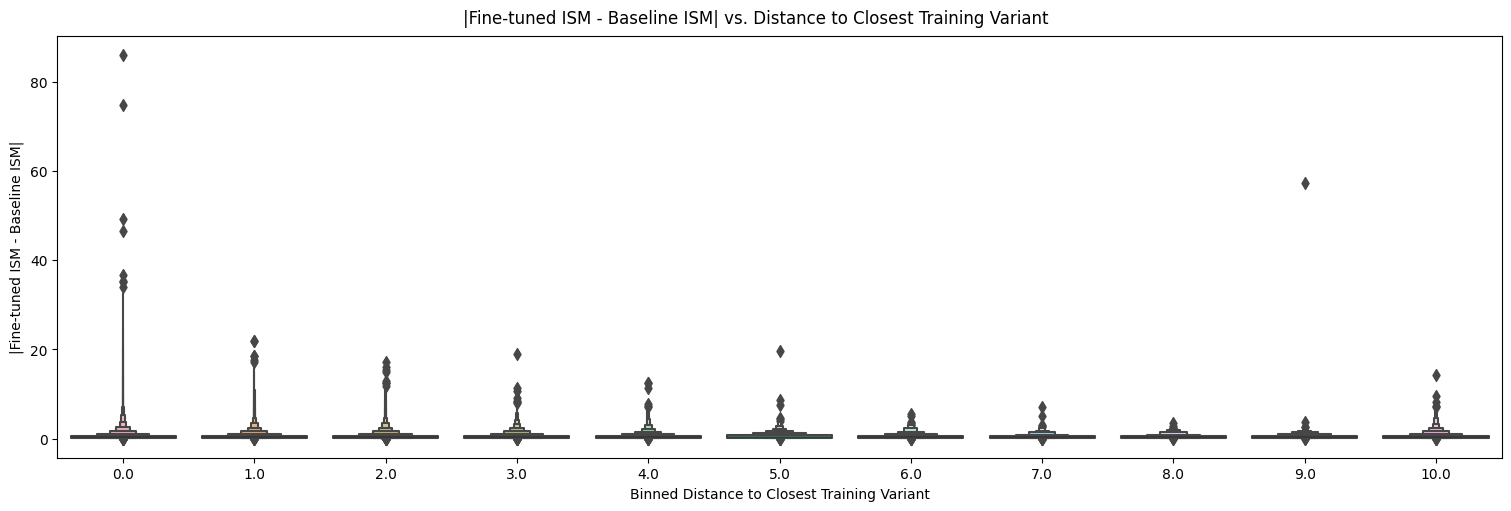

In [64]:
x = "|Fine-tuned ISM - Baseline ISM|"
y = "Distance to Closest Training Variant"
fig6, ax6 = plt.subplots(
    figsize=(15, 5), constrained_layout=True
)  # |Fine-tuned ISM| - |Baseline ISM| vs. Variant AF
variant_type = "Unobserved variants"
variant_df = plot_df[plot_df["Variant Type"] == variant_type].reset_index(drop=True)
variant_df[f"Binned {y}"] = variant_df[y] // 100
variant_df.loc[variant_df[f"Binned {y}"] > 10, f"Binned {y}"] = 10
sns.boxenplot(data=variant_df, y=x, x=f"Binned {y}", ax=ax6)
fig6.suptitle(f"{x} vs. {y}")
plt.show()

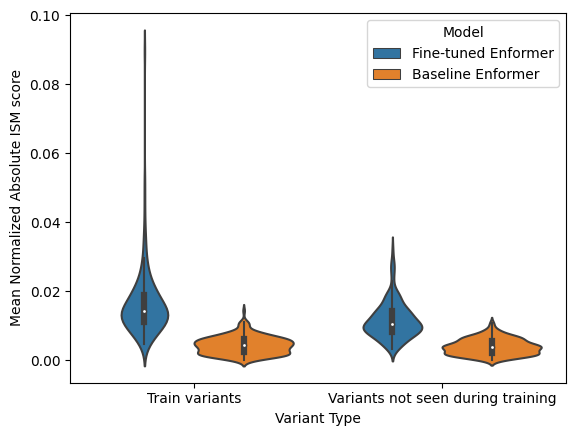

In [34]:
train_variants_ism_score_flat = np.concatenate(
    [train_variants_ism_score[gene].mean() for gene in train_variants_ism_score],
    axis=None,
)
test_val_exclusive_variants_ism_score_flat = np.concatenate(
    [
        test_val_exclusive_variants_ism_score[gene].mean()
        for gene in test_val_exclusive_variants_ism_score
    ],
    axis=None,
)

train_variants_baseline_enformer_ism_score_flat = np.concatenate(
    [
        train_variants_baseline_enformer_ism_score[gene].mean()
        for gene in train_variants_baseline_enformer_ism_score
    ],
    axis=None,
)
test_val_exclusive_variants_baseline_enformer_ism_score_flat = np.concatenate(
    [
        test_val_exclusive_variants_baseline_enformer_ism_score[gene].mean()
        for gene in test_val_exclusive_variants_baseline_enformer_ism_score
    ],
    axis=None,
)

plot_df = {}
plot_df["Variant Type"] = []
plot_df["Model"] = []
plot_df["Mean Normalized Absolute ISM score"] = []

for i in train_variants_ism_score_flat:
    plot_df["Variant Type"].append("Train variants")
    plot_df["Model"].append("Fine-tuned Enformer")
    plot_df["Mean Normalized Absolute ISM score"].append(i)

for i in test_val_exclusive_variants_ism_score_flat:
    plot_df["Variant Type"].append("Variants not seen during training")
    plot_df["Model"].append("Fine-tuned Enformer")
    plot_df["Mean Normalized Absolute ISM score"].append(i)

for i in train_variants_baseline_enformer_ism_score_flat:
    plot_df["Variant Type"].append("Train variants")
    plot_df["Model"].append("Baseline Enformer")
    plot_df["Mean Normalized Absolute ISM score"].append(i)

for i in test_val_exclusive_variants_baseline_enformer_ism_score_flat:
    plot_df["Variant Type"].append("Variants not seen during training")
    plot_df["Model"].append("Baseline Enformer")
    plot_df["Mean Normalized Absolute ISM score"].append(i)

plot_df = pd.DataFrame(plot_df)
sns.violinplot(
    data=plot_df, x="Variant Type", hue="Model", y="Mean Normalized Absolute ISM score"
)
plt.show()

<Axes: xlabel='Mean Normalized Absolute ISM score', ylabel='Count'>

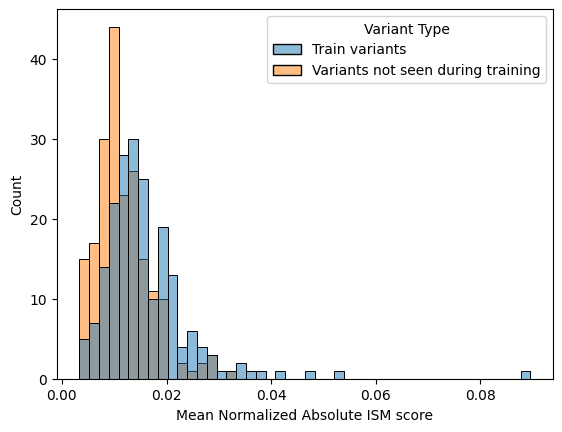

In [38]:
sns.histplot(
    data=plot_df[plot_df["Model"] == "Fine-tuned Enformer"].reset_index(drop=True),
    hue="Variant Type",
    x="Mean Normalized Absolute ISM score",
)

<Axes: xlabel='Mean Normalized Absolute ISM score', ylabel='Count'>

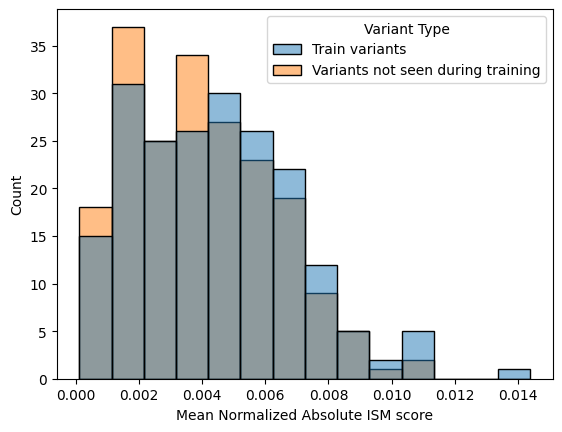

In [39]:
sns.histplot(
    data=plot_df[plot_df["Model"] == "Baseline Enformer"].reset_index(drop=True),
    hue="Variant Type",
    x="Mean Normalized Absolute ISM score",
)

  0%|          | 0/200 [00:00<?, ?it/s]

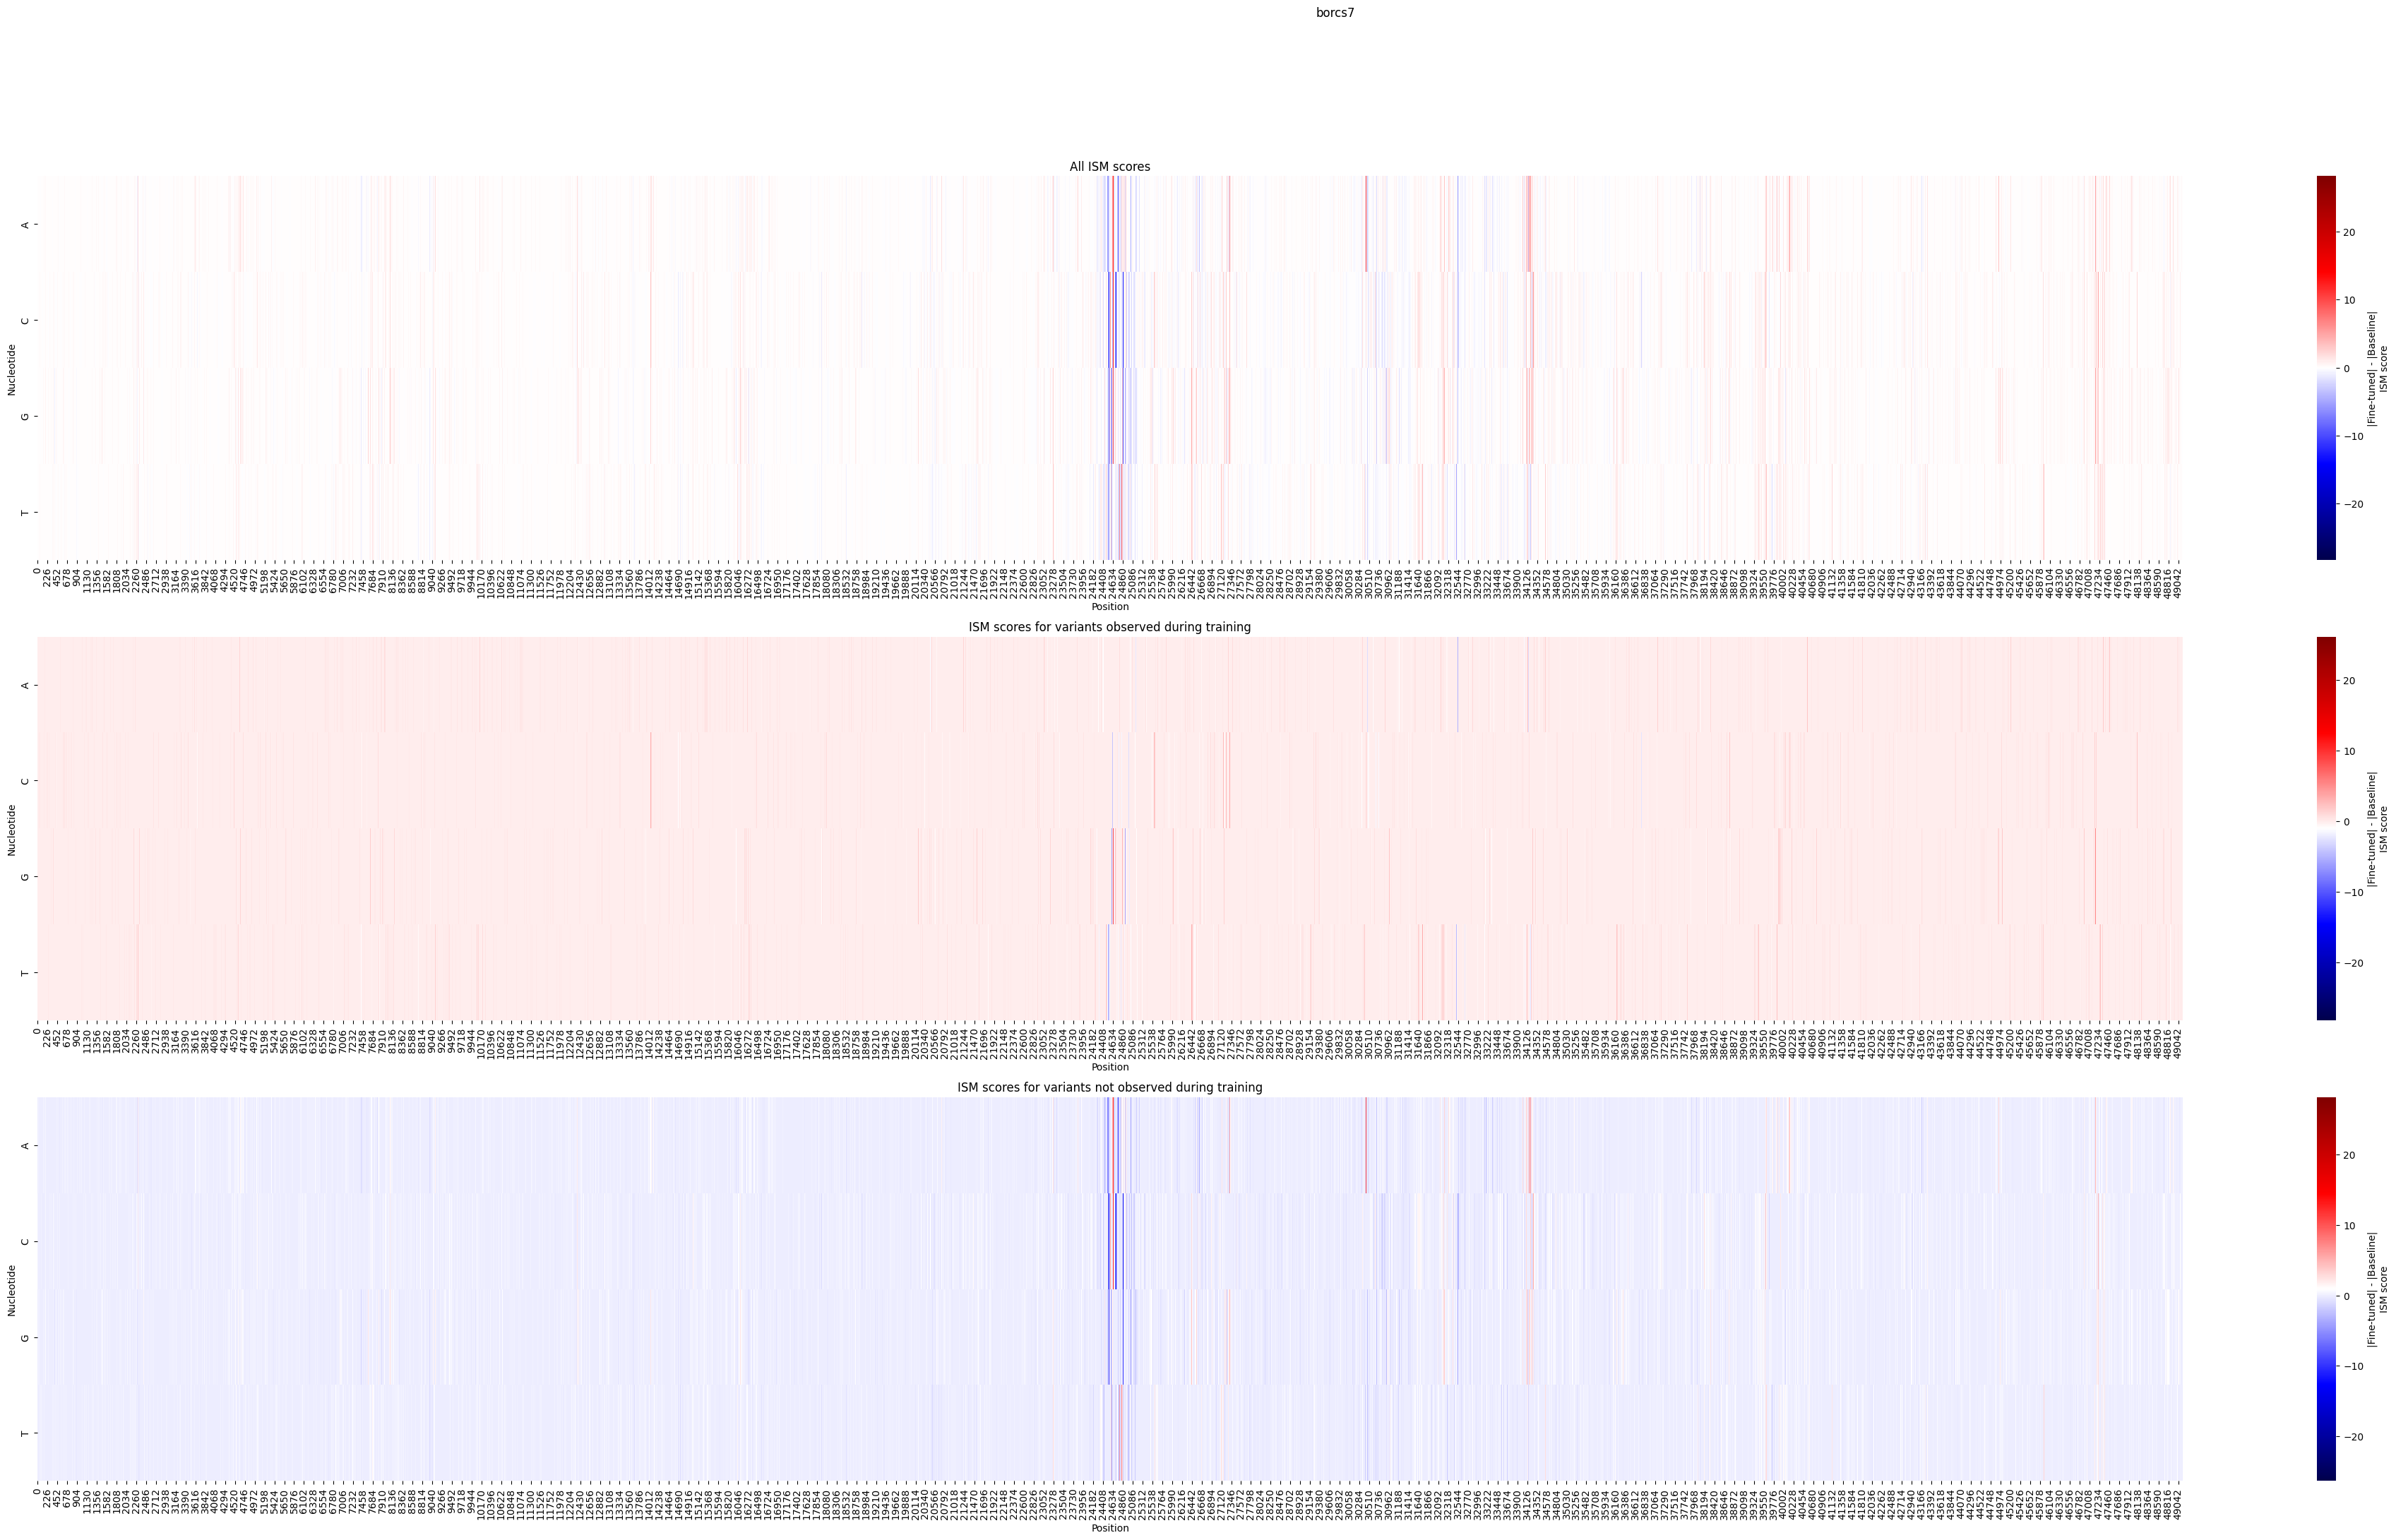

  0%|          | 0/200 [00:10<?, ?it/s]


In [62]:
x_scale_mult = 0.001
y_scale_mult = 2
for gene in tqdm(population_split_genes["gene"].unique()):
    finetuned_enformer_ISM_scores = stats.zscore(all_ism_scores[gene], axis=None)
    baseline_enformer_ISM_scores = stats.zscore(
        all_baseline_enformer_ism_scores[gene], axis=None
    )

    difference_in_abs_ISM_scores = np.abs(finetuned_enformer_ISM_scores) - np.abs(
        baseline_enformer_ISM_scores
    )

    fig, ax = plt.subplots(
        3,
        1,
        figsize=(
            int(x_scale_mult * finetuned_enformer_ISM_scores.shape[0]),
            3 * int(y_scale_mult * finetuned_enformer_ISM_scores.shape[1]),
        ),
    )

    sns.heatmap(
        data=difference_in_abs_ISM_scores.T,
        cmap="seismic",
        cbar_kws={"label": "|Fine-tuned| - |Baseline|\nISM score"},
        ax=ax[0],
    )
    ax[0].set_ylabel("Nucleotide")
    ax[0].set_yticklabels(["A", "C", "G", "T"])
    ax[0].set_xlabel("Position")
    ax[0].set_title("All ISM scores")

    variants_observed_during_training = train_afs[gene] != all_is_ref[gene]
    difference_in_abs_ISM_scores_for_variants_observed_during_training = (
        difference_in_abs_ISM_scores.copy()
    )
    difference_in_abs_ISM_scores_for_variants_observed_during_training[
        ~variants_observed_during_training
    ] = 0
    sns.heatmap(
        data=difference_in_abs_ISM_scores_for_variants_observed_during_training.T,
        cmap="seismic",
        cbar_kws={"label": "|Fine-tuned| - |Baseline|\nISM score"},
        ax=ax[1],
    )
    ax[1].set_ylabel("Nucleotide")
    ax[1].set_yticklabels(["A", "C", "G", "T"])
    ax[1].set_xlabel("Position")
    ax[1].set_title("ISM scores for variants observed during training")

    difference_in_abs_ISM_scores_for_variants_not_observed_during_training = (
        difference_in_abs_ISM_scores
        - difference_in_abs_ISM_scores_for_variants_observed_during_training
    )
    sns.heatmap(
        data=difference_in_abs_ISM_scores_for_variants_not_observed_during_training.T,
        cmap="seismic",
        cbar_kws={"label": "|Fine-tuned| - |Baseline|\nISM score"},
        ax=ax[2],
    )
    ax[2].set_ylabel("Nucleotide")
    ax[2].set_yticklabels(["A", "C", "G", "T"])
    ax[2].set_xlabel("Position")
    ax[2].set_title("ISM scores for variants not observed during training")

    fig.suptitle(gene)
    plt.show()

    break